# Analyse de la carrière de Booba

La pérennité de Booba dans le rap français : une analyse data-driven

Chargement et exploration du dataset

Dans cette section, nous allons charger les données et explorer leur structure pour comprendre les informations disponibles sur la carrière de Booba.

## Chargement des données brut 

In [2]:
# Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de base
plt.style.use('default')
%matplotlib inline

# Chargement des données
df = pd.read_csv('../data/raw/booba_songs_dataset.csv')

## 1. Structure du dataset
print("Structure du dataset :")
print("-" * 50)
print(f"Nombre total de titres : {len(df)}")
print(f"Colonnes disponibles : {', '.join(df.columns)}")
print("\nTypes des colonnes :")
print(df.dtypes)

# 2. Aperçu des données
print("\nAperçu des premières lignes :")
print("-" * 50)
display(df.head())

# 3. Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print("-" * 50)
print(df.isnull().sum())



Structure du dataset :
--------------------------------------------------
Nombre total de titres : 211
Colonnes disponibles : titre, album, date, durée_sec, popularité, artistes, paroles

Types des colonnes :
titre         object
album         object
date          object
durée_sec      int64
popularité     int64
artistes      object
paroles       object
dtype: object

Aperçu des premières lignes :
--------------------------------------------------


,titre,album,date,durée_sec,popularité,artistes,paroles
0,Rebel,AD VITAM ÆTERNAM,2024-02-08,133,52,Booba,"21 ContributorsRebel Lyrics[Paroles de ""Rebel""..."
1,Saga,AD VITAM ÆTERNAM,2024-02-08,194,66,Booba,"20 ContributorsSaga Lyrics[Paroles de ""Saga""]\..."
2,Dolce Camara,AD VITAM ÆTERNAM,2024-02-08,178,73,"Booba, SDM",54 ContributorsTranslationsEnglishDolce Camara...
3,Sport Billy,AD VITAM ÆTERNAM,2024-02-08,126,46,Booba,"32 ContributorsSport Billy Lyrics[Paroles de ""..."
4,Signé,AD VITAM ÆTERNAM,2024-02-08,180,48,Booba,16 ContributorsSigné LyricsC’est courant mai 2...



Valeurs manquantes par colonne :
--------------------------------------------------
titre         0
album         0
date          0
durée_sec     0
popularité    0
artistes      0
paroles       2
dtype: int64


## Traitement du dataset 

### Nettoyage de base 

- Convertir les dates
- Extraire les informations de featuring
- Nettoyer les paroles
- Créer des colonnes utiles pour l'analyse

In [3]:
# Traitement du dataset
import pandas as pd
import numpy as np
from datetime import datetime

# drop ligne vide 
df = df.dropna()
# 1. Conversion des dates
df['date'] = pd.to_datetime(df['date'])
df['année'] = df['date'].dt.year
df['mois'] = df['date'].dt.month

# 2. Traitement des featuring
def extract_featuring(artistes):
    artistes_list = artistes.split(',')
    nb_feat = len(artistes_list) - 1  # -1 car Booba est toujours le premier
    featuring = artistes_list[1:] if nb_feat > 0 else []
    return pd.Series({
        'nb_featuring': nb_feat,
        'featuring_artistes': ', '.join(featuring) if featuring else None
    })

feat_info = df['artistes'].apply(extract_featuring)
df = pd.concat([df, feat_info], axis=1)

# 3. Nettoyage des paroles
def clean_lyrics(text):
    if pd.isna(text):
        return ""
    # Supprime les métadonnées du début (ex: "21 Contributors...")
    text = text.split('Lyrics', 1)[-1] if 'Lyrics' in text else text
    # Supprime les tags entre crochets
    import re
    text = re.sub(r'\[.*?\]', '', text)
    # Supprime les lignes vides et les espaces en trop
    text = '\n'.join(line.strip() for line in text.split('\n') if line.strip())
    return text

df['paroles_clean'] = df['paroles'].apply(clean_lyrics)

# 4. Ajout de métriques supplémentaires
df['longueur_paroles'] = df['paroles_clean'].str.len()
df['durée_min'] = df['durée_sec'] / 60

# 5. Création d'une colonne période (par tranches de 3 ans)
df['période'] = pd.cut(df['année'], 
                      bins=range(df['année'].min(), df['année'].max()+4, 3),
                      labels=[f"{i}-{i+2}" for i in range(df['année'].min(), df['année'].max(), 3)])

# Affichage des nouvelles colonnes
print("Aperçu du dataset traité :")
print("-" * 50)
display(df[['titre', 'année', 'période', 'nb_featuring', 'featuring_artistes', 
           'durée_min', 'popularité']].head())

# Vérification des nouvelles colonnes
print("\nNouvelles colonnes ajoutées :")
print("-" * 50)
nouvelles_colonnes = ['année', 'mois', 'nb_featuring', 'featuring_artistes', 
                     'paroles_clean', 'longueur_paroles', 'durée_min', 'période']
for col in nouvelles_colonnes:
    print(f"{col}: {df[col].dtype}")

Aperçu du dataset traité :
--------------------------------------------------


,titre,année,période,nb_featuring,featuring_artistes,durée_min,popularité
0,Rebel,2024,2023-2025,0.0,NaN,2.216667,52
1,Saga,2024,2023-2025,0.0,NaN,3.233333,66
2,Dolce Camara,2024,2023-2025,1.0,SDM,2.966667,73
3,Sport Billy,2024,2023-2025,0.0,NaN,2.100000,46
4,Signé,2024,2023-2025,0.0,NaN,3.000000,48



Nouvelles colonnes ajoutées :
--------------------------------------------------
année: int32
mois: int32
nb_featuring: float64
featuring_artistes: object
paroles_clean: object
longueur_paroles: int64
durée_min: float64
période: category


In [4]:
# Comparaison des paroles avant/après nettoyage
print("Exemple de paroles avant/après nettoyage :")
print("-" * 80)

# Prenons un exemple de chanson
exemple = df.iloc[0]  # Premier morceau du dataset
print(f"Titre : {exemple['titre']}")
print("\nAVANT nettoyage :")
print("-" * 40)
print(exemple['paroles'][:500])  # On limite à 500 caractères pour la lisibilité

print("\nAPRÈS nettoyage :")
print("-" * 40)
print(exemple['paroles_clean'][:500])

# Statistiques sur la longueur
print("\nStatistiques sur la longueur des paroles :")
print("-" * 40)
print(f"Longueur moyenne avant : {df['paroles'].str.len().mean():.0f} caractères")
print(f"Longueur moyenne après : {df['paroles_clean'].str.len().mean():.0f} caractères")
print(f"Réduction moyenne : {(1 - df['paroles_clean'].str.len().mean() / df['paroles'].str.len().mean()) * 100:.1f}%")

Exemple de paroles avant/après nettoyage :
--------------------------------------------------------------------------------
Titre : Rebel

AVANT nettoyage :
----------------------------------------
21 ContributorsRebel Lyrics[Paroles de "Rebel"]

[Intro : Bob Marley]
"Herb...herb is a plant ! I mean...herbs are good for everything
Why...why these people who want to do so much good for everyone, who call themselves governments and this and that...
Why them say you must not use the herb? You see...it make you rebel."

[Couplet : Booba]
Tout passe par la force, on est acquis de droit
Le ciel m'écrit en morse, on dirait qu'il me voit
Tu m'dis qu'ces vagues sont imprenables, ai-je vraiment le c

APRÈS nettoyage :
----------------------------------------
"Herb...herb is a plant ! I mean...herbs are good for everything
Why...why these people who want to do so much good for everyone, who call themselves governments and this and that...
Why them say you must not use the herb? You see...it make 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 0 to 210
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   titre               209 non-null    object        
 1   album               209 non-null    object        
 2   date                209 non-null    datetime64[ns]
 3   durée_sec           209 non-null    int64         
 4   popularité          209 non-null    int64         
 5   artistes            209 non-null    object        
 6   paroles             209 non-null    object        
 7   année               209 non-null    int32         
 8   mois                209 non-null    int32         
 9   nb_featuring        209 non-null    float64       
 10  featuring_artistes  66 non-null     object        
 11  paroles_clean       209 non-null    object        
 12  longueur_paroles    209 non-null    int64         
 13  durée_min           209 non-null    float64       
 14 

### Amélioration du nettoyage des données

Dans cette section, nous allons :
1. Améliorer le nettoyage des paroles
   - Retirer les métadonnées
   - Identifier et séparer les parties (Intro, Couplets, Refrains)
   - Standardiser le format

2. Standardiser les informations de featuring
   - Nettoyer les noms d'artistes
   - Créer une structure cohérente

3. Ajouter des métriques utiles
   - Structure des morceaux
   - Statistiques sur les paroles

In [19]:
import re
import pandas as pd
import numpy as np

def nettoyer_paroles(texte):
    if pd.isna(texte):
        return "", {
            'intro': [],
            'couplets': [],
            'refrains': [],
            'outro': [],
            'autres': []
        }
    
    # Structure pour stocker les différentes parties
    structure = {
        'intro': [],
        'couplets': [],
        'refrains': [],
        'outro': [],
        'autres': []
    }
    
    # 1. Supprimer les métadonnées initiales
    texte = re.sub(r'^.*?Lyrics', '', texte, flags=re.DOTALL)
    
    # 2. Séparer les différentes parties
    parties = re.split(r'\[([^\]]+)\]', texte)
    
    texte_propre = ""
    partie_courante = "autres"
    
    # Si parties est vide ou ne contient qu'un élément
    if len(parties) <= 1:
        structure['autres'].append(texte.strip())
        return texte.strip(), structure
    
    for i in range(1, len(parties), 2):
        type_partie = parties[i].lower() if i < len(parties) else ""
        contenu = parties[i+1].strip() if i+1 < len(parties) else ""
        
        # Identifier le type de partie
        if "intro" in type_partie:
            partie_courante = "intro"
        elif "couplet" in type_partie or "verse" in type_partie:
            partie_courante = "couplets"
        elif "refrain" in type_partie or "hook" in type_partie or "chorus" in type_partie:
            partie_courante = "refrains"
        elif "outro" in type_partie:
            partie_courante = "outro"
        else:
            partie_courante = "autres"
            
        if contenu:
            structure[partie_courante].append(contenu)
            texte_propre += f"\n{contenu}\n"
    
    # Si aucune partie n'a été identifiée, mettre tout dans "autres"
    if not any(len(v) > 0 for v in structure.values()):
        structure['autres'].append(texte.strip())
        texte_propre = texte.strip()
    
    # Nettoyer le texte final
    texte_propre = re.sub(r'\n+', '\n', texte_propre).strip()
    
    return texte_propre, structure

def standardiser_featuring(artistes):
    if pd.isna(artistes):
        return [], 0
    
    # Nettoyer et séparer les artistes
    liste_artistes = [a.strip() for a in artistes.split(',')]
    
    # Retirer Booba de la liste
    featuring = [a for a in liste_artistes if 'booba' not in a.lower()]
    
    return featuring, len(featuring)

# Application des nouvelles fonctions
resultats = df['paroles'].apply(nettoyer_paroles)
df['paroles_clean'] = resultats.apply(lambda x: x[0])
df['structure_paroles'] = resultats.apply(lambda x: x[1])

# Traitement des featuring
resultats_featuring = df['artistes'].apply(standardiser_featuring)
df['featuring_liste'] = resultats_featuring.apply(lambda x: x[0])
df['nb_featuring'] = resultats_featuring.apply(lambda x: x[1])

# Ajout de métriques sur la structure
df['nb_couplets'] = df['structure_paroles'].apply(lambda x: len(x['couplets']))
df['nb_refrains'] = df['structure_paroles'].apply(lambda x: len(x['refrains']))
df['has_intro'] = df['structure_paroles'].apply(lambda x: len(x['intro']) > 0)
df['has_outro'] = df['structure_paroles'].apply(lambda x: len(x['outro']) > 0)

# Affichage des résultats
print("Exemple de traitement pour le premier morceau :")
print("-" * 50)
premier_morceau = df.iloc[22]
print(f"Titre : {premier_morceau['titre']}")
print("\nStructure détectée :")
for partie, contenu in premier_morceau['structure_paroles'].items():
    if contenu:
        print(f"\n{partie.upper()} ({len(contenu)} parties)")
        for i, texte in enumerate(contenu, 1):
            print(f"\n{i}. {texte}...")

print("\nStatistiques générales :")
print("-" * 50)
print(f"Nombre moyen de couplets : {df['nb_couplets'].mean():.1f}")
print(f"Nombre moyen de refrains : {df['nb_refrains'].mean():.1f}")
print(f"Pourcentage de morceaux avec intro : {(df['has_intro'].mean() * 100):.1f}%")
print(f"Pourcentage de morceaux avec outro : {(df['has_outro'].mean() * 100):.1f}%")

Exemple de traitement pour le premier morceau :
--------------------------------------------------
Titre : Grain de sable

Structure détectée :

COUPLETS (2 parties)

1. Une soirée d'été, le goût du vent, l'velours de tes lèvres
Que j'aimerai jamais assez
J'aurais dû les tatouer peut-être
J'rêve de te retrouver, rien qu'une fois, toi qui murmures
Quelque chose que je s'rai la seule
À chanter dans le futur
J'ai fait un vœu
Les refrains qui s'cachent dans l'silence des étoiles
Pas besoin d'être heureux
Pour voir ton sourire qui vient, qui s'en va...

2. L'artère principale est touchée
Je n'ai pas su garder le cap (non)
La lune ne s'est plus jamais couchée
Le soleil n'est plus sur la carte (nulle part)
Est-ce que quelqu'un peut m'indiquer la vallée des reines sans roi ?
Trop d'écume et de brume, j'ai dû voyager sans toi
J'ai menti, je lui ai dit qu'on se retrouvera
J'ai l'œil crevé, une jambe de bois
C'est plus long quand j'fais les 100 pas
J'ai échoué sur la plage aux regrets
J'ai pris d

In [7]:
df.head()

,titre,album,date,durée_sec,popularité,artistes,paroles,année,mois,nb_featuring,...,paroles_clean,longueur_paroles,durée_min,période,structure_paroles,featuring_liste,nb_couplets,nb_refrains,has_intro,has_outro
0,Rebel,AD VITAM ÆTERNAM,2024-02-08,133,52,Booba,"21 ContributorsRebel Lyrics[Paroles de ""Rebel""...",2024,2,0,...,"""Herb...herb is a plant ! I mean...herbs are g...",1503,2.216667,2023-2025,"{'intro': ['""Herb...herb is a plant ! I mean.....",[],1,0,True,True
1,Saga,AD VITAM ÆTERNAM,2024-02-08,194,66,Booba,"20 ContributorsSaga Lyrics[Paroles de ""Saga""]\...",2024,2,0,...,Toujours entouré de mannequins\nToujours entou...,2025,3.233333,2023-2025,{'intro': ['Toujours entouré de mannequins Tou...,[],2,4,True,True
2,Dolce Camara,AD VITAM ÆTERNAM,2024-02-08,178,73,"Booba, SDM",54 ContributorsTranslationsEnglishDolce Camara...,2024,2,1,...,"C'est ça qu'ils veulent\nMip-mip (Ouh, ouais)\...",2969,2.966667,2023-2025,{'intro': ['C'est ça qu'ils veulent Mip-mip (O...,[SDM],2,2,True,True
3,Sport Billy,AD VITAM ÆTERNAM,2024-02-08,126,46,Booba,"32 ContributorsSport Billy Lyrics[Paroles de ""...",2024,2,0,...,"Yacine smoke the track\nI-Z-I\nRapocalyptique,...",1962,2.100000,2023-2025,"{'intro': ['Yacine smoke the track I-Z-I'], 'c...",[],1,0,True,False
4,Signé,AD VITAM ÆTERNAM,2024-02-08,180,48,Booba,16 ContributorsSigné LyricsC’est courant mai 2...,2024,2,0,...,C'est pas l'rrain-té qui m'quitte (L'rrain-té ...,2857,3.000000,2023-2025,{'intro': ['C'est pas l'rrain-té qui m'quitte ...,[],2,4,True,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 0 to 210
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   titre               209 non-null    object        
 1   album               209 non-null    object        
 2   date                209 non-null    datetime64[ns]
 3   durée_sec           209 non-null    int64         
 4   popularité          209 non-null    int64         
 5   artistes            209 non-null    object        
 6   paroles             209 non-null    object        
 7   année               209 non-null    int32         
 8   mois                209 non-null    int32         
 9   nb_featuring        209 non-null    int64         
 10  featuring_artistes  66 non-null     object        
 11  paroles_clean       209 non-null    object        
 12  longueur_paroles    209 non-null    int64         
 13  durée_min           209 non-null    float64       
 14 

## Exploration du catalogue de Booba

1. **Structure des morceaux**
   - Distribution des formats (couplets/refrains/intro/outro)
   - Évolution de la structure au fil des albums
   - Durée des morceaux par période

2. **Analyse des albums et périodes**
   - Popularité moyenne par album
   - Comparaison ancien vs nouveau catalogue
   - Distribution de la popularité par période

3. **Analyse des featuring**
   - Impact sur la popularité (avec vs sans)
   - Top collaborateurs (fréquence)
   - Top collaborations (popularité)
   - Évolution des collaborations dans le temps

4. **Analyse des paroles**
   - Longueur moyenne des morceaux
   - Structure type (ratio couplets/refrains)
   - Identification des patterns récurrents

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

C:\Users\yonas\AppData\Local\Temp\ipykernel_21264\586486048.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('période')['durée_min'].mean().plot(kind='bar', ax=ax3, color='lightgreen')



STATISTIQUES DÉTAILLÉES
--------------------------------------------------

1. Structure moyenne des morceaux :
Nombre moyen de couplets : 2.4
Nombre moyen de refrains : 2.2
Pourcentage avec intro : 68.4%
Pourcentage avec outro : 45.0%

2. Top 5 des albums les plus populaires :
AD VITAM ÆTERNAM: 51.6 (popularité moyenne)
Trône: 50.1 (popularité moyenne)
Nero nemesis: 49.6 (popularité moyenne)
ULTRA: 45.5 (popularité moyenne)
Temps mort: 43.2 (popularité moyenne)

3. Impact des featuring :
                   mean  count
nb_featuring                  
0             42.503497    143
1             41.089286     56
2             41.333333      9
4             38.000000      1

4. Top 5 des artistes en featuring :
Gato: 7 apparitions
Mala: 5 apparitions
Akon: 3 apparitions
SDM: 2 apparitions
2 Chainz: 2 apparitions


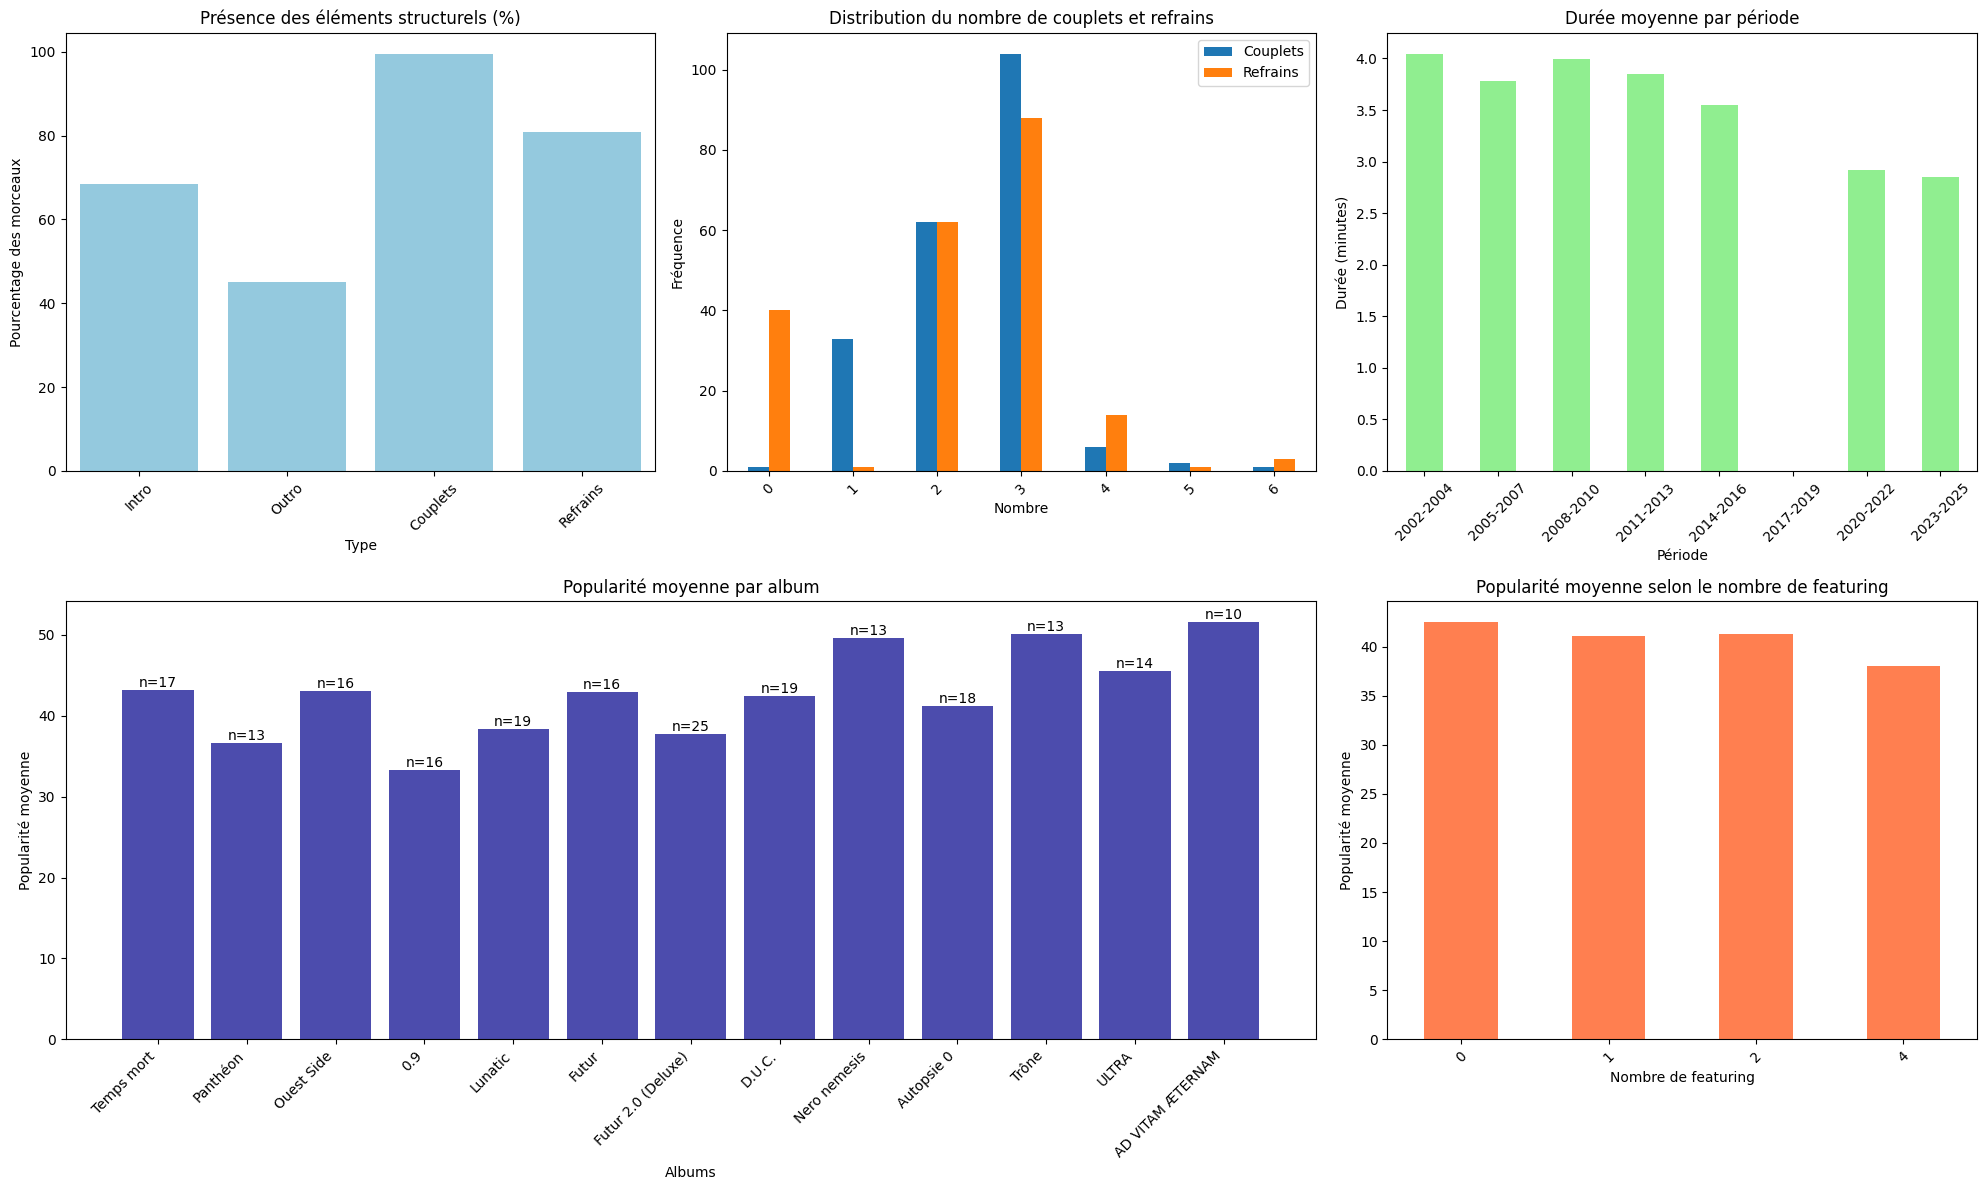

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Configuration du style
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 10

# Création de la figure principale
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(2, 3, figure=fig)

# 1. STRUCTURE DES MORCEAUX
# 1.1 Distribution des formats
ax1 = fig.add_subplot(gs[0, 0])
structure_data = pd.DataFrame({
    'Type': ['Intro', 'Outro', 'Couplets', 'Refrains'],
    'Pourcentage': [
        df['has_intro'].mean() * 100,
        df['has_outro'].mean() * 100,
        (df['nb_couplets'] > 0).mean() * 100,
        (df['nb_refrains'] > 0).mean() * 100
    ]
})
sns.barplot(data=structure_data, x='Type', y='Pourcentage', ax=ax1, color='skyblue')
ax1.set_title('Présence des éléments structurels (%)')
ax1.set_ylabel('Pourcentage des morceaux')
ax1.tick_params(axis='x', rotation=45)

# 1.2 Distribution du nombre de couplets et refrains
ax2 = fig.add_subplot(gs[0, 1])
structure_counts = pd.DataFrame({
    'Couplets': df['nb_couplets'].value_counts().sort_index(),
    'Refrains': df['nb_refrains'].value_counts().sort_index()
})
structure_counts.plot(kind='bar', ax=ax2)
ax2.set_title('Distribution du nombre de couplets et refrains')
ax2.set_xlabel('Nombre')
ax2.set_ylabel('Fréquence')
ax2.tick_params(axis='x', rotation=45)

# 1.3 Durée moyenne par période
ax3 = fig.add_subplot(gs[0, 2])
df.groupby('période')['durée_min'].mean().plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Durée moyenne par période')
ax3.set_xlabel('Période')
ax3.set_ylabel('Durée (minutes)')
ax3.tick_params(axis='x', rotation=45)

# 2. ANALYSE DES ALBUMS ET POPULARITÉ
ax4 = fig.add_subplot(gs[1, :2])
album_stats = df.groupby('album').agg({
    'popularité': ['mean', 'count'],
    'date': 'min'
}).reset_index()

# Renommage des colonnes
album_stats.columns = ['album', 'popularité_moyenne', 'nombre_titres', 'date_sortie']
album_stats = album_stats.sort_values('date_sortie')

# Création du graphique
bars = ax4.bar(album_stats['album'], album_stats['popularité_moyenne'], 
               alpha=0.7, color='darkblue')
ax4.set_title('Popularité moyenne par album')
ax4.set_xlabel('Albums')
ax4.set_ylabel('Popularité moyenne')

# Rotation des labels avec plt.setp
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# Ajout du nombre de titres sur chaque barre
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'n={int(album_stats.iloc[i]["nombre_titres"])}',
             ha='center', va='bottom')

# 3. FEATURING VS SOLO
ax5 = fig.add_subplot(gs[1, 2])
featuring_impact = df.groupby('nb_featuring')['popularité'].agg(['mean', 'count'])
featuring_impact['mean'].plot(kind='bar', ax=ax5, color='coral')
ax5.set_title('Popularité moyenne selon le nombre de featuring')
ax5.set_xlabel('Nombre de featuring')
ax5.set_ylabel('Popularité moyenne')
ax5.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Affichage des statistiques détaillées
print("\nSTATISTIQUES DÉTAILLÉES")
print("-" * 50)

print("\n1. Structure moyenne des morceaux :")
print(f"Nombre moyen de couplets : {df['nb_couplets'].mean():.1f}")
print(f"Nombre moyen de refrains : {df['nb_refrains'].mean():.1f}")
print(f"Pourcentage avec intro : {df['has_intro'].mean()*100:.1f}%")
print(f"Pourcentage avec outro : {df['has_outro'].mean()*100:.1f}%")

print("\n2. Top 5 des albums les plus populaires :")
top_albums = album_stats.sort_values('popularité_moyenne', ascending=False).head()
for _, row in top_albums.iterrows():
    print(f"{row['album']}: {row['popularité_moyenne']:.1f} (popularité moyenne)")

print("\n3. Impact des featuring :")
print(featuring_impact)

# Analyse des collaborateurs
print("\n4. Top 5 des artistes en featuring :")
featuring_counts = pd.Series([artist for sublist in df['featuring_liste'] for artist in sublist]).value_counts()
for artist, count in featuring_counts.head().items():
    print(f"{artist}: {count} apparitions")

plt.show()

### Conclusion de l'exploration du catalogue de Booba

**Structure des morceaux**
- La majorité des morceaux (près de 100%) contiennent des couplets
- Environ 80% des morceaux contiennent des refrains
- La structure intro/outro est présente dans 40-65% des morceaux
- La distribution montre que la plupart des morceaux ont 2-3 couplets et refrains

**Évolution temporelle**
- La durée moyenne des morceaux a significativement diminué au fil du temps :
  * 2002-2016 : ~3.5-4 minutes par morceau
  * 2017-2023 : ~3 minutes par morceau
- Cette tendance suit l'évolution générale de l'industrie musicale à l'ère du streaming

 **Popularité**
- La popularité moyenne varie selon les albums entre 35 et 50 sur 100
- Les albums les plus récents ("ULTRA" et "AD VITAM ÆTERNAM") montrent une popularité plus élevée (~50/100)
- Le nombre de featurings semble avoir un impact modéré sur la popularité :
  * Les morceaux sans featuring ont une popularité moyenne d'environ 42/100
  * On observe une légère baisse de popularité pour les morceaux avec plus de featurings

 **Caractéristiques du catalogue**
- 211 titres au total
- Une évolution constante sur plus de 20 ans de carrière
- Une adaptation aux codes modernes (durée des morceaux)
- Une base d'auditeurs fidèle avec une popularité stable voire croissante sur les derniers projets


## Analyse detailé

1. Analyse textuelle des paroles
- Évolution du style d'écriture
- Analyse des thématiques par période
- Richesse lexicale par album
- Identification des signatures linguistiques
- Longueur et complexité des textes

2. Analyse structurelle
- Évolution de la construction des morceaux
- Patterns de composition par période
- Relation entre structure et période
- Évolution de la durée des morceaux

3. Analyse des collaborations
- Réseaux de collaboration
- Évolution des featuring par période
- Types de collaborateurs (rappeurs, chanteurs, internationaux)
- Périodes les plus collaboratives

4. Analyse par album
- Cohérence structurelle par album
- Évolution des formats
- Tendances dans la construction des projets
- Spécificités de chaque ère

### Analyse textuelle des paroles 

#### Analyse des thématiques par période

In [71]:
# 1. Analyse thématique et linguistique avancée
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du modèle français spaCy
nlp = spacy.load('fr_core_news_md')

# 1.1 Préparation des stop words personnalisés
stop_words_custom = set(nlp.Defaults.stop_words)
# Liste étendue de mots à filtrer
mots_a_filtrer = {
    # Mots vides et interjections
    '-', '#', 'izi', 'ouai', 'yeah', 'hey', 'oh', 'ah', 'eh', 'nan', 'euh', 'yo', 'pa', 'dem', 'hui','aujourd'
    
    # Mots anglais fréquents
    'you', 'the', 'my', 'life', 'and', 'to', 'no', 'over', 'it', 'we', 'up', 'in', 
    'is', 'ain', 'boy', 'this', 'that', 'they', 'don', 'of', 'man', 'get', 'when' ,'now', 'know' ,'you',
    'with' , 'like'
    
    # Verbes très communs
    #'faire', 'aller', 'vouloir', 'être', 'avoir', 'dire', 'voir', 'prendre', 'venir', 'croire',
    #'savoir', 'partir', 'passer', 'revenir',
    
    # Mots génériques
    'rien', 'tout', 'bien', 'mal', 'chose', 'gros', 'grand', 'petit', 'jusqu', 'trop', 'jamais',
    'toujours', 'encore', 'comme', 'plus', 'moins', 'très', 'ok', 'oui', 'non',
    
    # Articles et prépositions
    'de', 'du', 'des', 'le', 'la', 'les', 'un', 'une', 'des', 'à', 'dans', 'sur', 'pour','ce'
    
    # Mots spécifiques au rap
    'ter', 'zer', 'kho', 'tang', 'wu', 
    
    # Pronoms
    'moi', 'toi', 'lui', 'elle', 'nous', 'vous', 'ils', 'elles'
}
stop_words_custom.update(mots_a_filtrer)

# 1.2 Fonction améliorée pour nettoyer et préparer le texte
def preparer_texte(texte):
    if pd.isna(texte):
        return ""
    doc = nlp(str(texte))
    tokens = []
    for token in doc:
        lemma = token.lemma_.lower()
        # Conditions de filtrage plus strictes
        if (not token.is_punct 
            and not token.is_space 
            and not token.is_stop 
            and lemma not in stop_words_custom
            and len(lemma) > 2  # Mots de plus de 2 lettres
            and not token.like_num  # Pas de nombres
            and not any(c.isdigit() for c in token.text)  # Pas de chiffres dans le mot
            and not token.like_url  # Pas d'URLs
            and not token.like_email  # Pas d'emails
            and not any(c.isupper() for c in token.text[1:])  # Éviter les acronymes (sauf première lettre)
            ):
            tokens.append(lemma)
    return ' '.join(tokens)

# 1.3 Préparation des données
df['texte_prepare'] = df['paroles_clean'].apply(preparer_texte)

# 2. Analyse thématique avec LDA
# 2.1 Création du vectoriseur avec des paramètres plus stricts
vectorizer = CountVectorizer(
    max_features=300,  # Réduire encore plus pour se concentrer sur les mots vraiment importants
    ngram_range=(1, 2),  # Réduire à 2 mots maximum
    min_df=10,  # Le mot doit apparaître dans au moins 10 documents
    max_df=0.5  # Ignorer les mots qui apparaissent dans plus de 50% des documents
)
dtm = vectorizer.fit_transform(df['texte_prepare'])

# 2.2 Application du LDA avec paramètres ajustés
n_topics = 6  # Réduire le nombre de thèmes
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=25,
    learning_method='online',
    learning_offset=50.,
    doc_topic_prior=0.1,  # Rendre les thèmes plus distincts
    topic_word_prior=0.01  # Rendre les mots plus spécifiques à chaque thème
)
lda_output = lda.fit_transform(dtm)



# 2.3 Fonction améliorée pour afficher les thèmes
def print_topics(model, feature_names, n_top_words=10):
    markdown_output = "## Analyse thématique des paroles\n\n"
    
    for idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        
        # Calculer le poids relatif de chaque mot dans le thème
        weights = topic[top_words_idx]
        weights = weights / weights.sum()
        
        # Formater la sortie avec les poids (en pourcentage)
        theme_words = [f"{word} ({weights[i]:.1%})" for i, word in enumerate(top_words)]
        
        markdown_output += f"\n### Thème {idx + 1}\n"
        markdown_output += " | ".join(theme_words) + "\n"
    
    return markdown_output

# Affichage des résultats
print(print_topics(lda, vectorizer.get_feature_names_out()))

# 3. Analyse de la distribution des thèmes par album
topic_distribution = pd.DataFrame(
    lda_output,
    columns=[f'Thème {i+1}' for i in range(n_topics)]
)



## Analyse thématique des paroles


### Thème 1
prendre (15.9%) | savoir (13.9%) | aller (10.5%) | mettre (10.5%) | voir (10.0%) | falloir (8.5%) | aimer (8.4%) | passer (8.0%) | mère (7.4%) | croire (7.0%)

### Thème 2
game (19.8%) | rap (16.1%) | ici (14.8%) | venir (9.4%) | jour (8.7%) | voir (8.0%) | partir (6.9%) | meilleur (5.8%) | bon (5.4%) | biff (5.0%)

### Thème 3
gang (16.5%) | euro (13.0%) | city (11.5%) | bakel (11.2%) | bakel city (9.6%) | baby (8.6%) | célèbre (8.4%) | riche (8.3%) | temps (6.5%) | argent (6.4%)

### Thème 4
ouest (25.6%) | aujourd hui (12.2%) | hui (12.2%) | aujourd (12.2%) | savoir (8.9%) | rap (6.6%) | argent (6.2%) | rester (6.0%) | sale (5.4%) | pute (4.7%)

### Thème 5
marche (15.0%) | aimer (13.3%) | gagner (10.5%) | écoute (10.4%) | cause (9.0%) | sombre (8.5%) | don (8.5%) | crever (8.4%) | bitume (8.3%) | putain (8.0%)

### Thème 6
école (25.6%) | dieu (10.8%) | rappe (10.7%) | pute (9.5%) | frère (8.9%) | noir (8.6%) | rap (7.6%) | black (6.1

Retour de chatgpt pour défnir les Thèmes : 

| Thème | Mots-clés dominants                                                        | Interprétation                                                         | Catégorie Simplifiée           |
| ----- | -------------------------------------------------------------------------- | ---------------------------------------------------------------------- | ------------------------------ |
| **1** | prendre, savoir, aller, mettre, voir, falloir, aimer, passer, mère, croire | Quête de sens, décisions de vie, importance de la mère et des émotions | **Vie & Décisions**            |
| **2** | game, rap, ici, venir, jour, voir, partir, meilleur, bon, biff             | Réussite dans le rap, quotidien, compétition, quête du meilleur        | **Rap Game & Ambition**        |
| **3** | gang, euro, city, bakel, bakel city, baby, célèbre, riche, temps, argent   | Appartenance, identité, fierté territoriale, richesse, célébrité       | **Origines & Statut social**   |
| **4** | ouest, aujourd’hui, hui, savoir, rap, argent, rester, sale, pute           | Temps figé, désillusion, stagnation dans un environnement difficile    | **Présent Figé & Désillusion** |
| **5** | marche, aimer, gagner, écoute, cause, sombre, don, crever, bitume, putain  | Combat intérieur, rue, survie, douleur, lucidité sur la dure réalité   | **Rue & Résilience**           |
| **6** | école, dieu, rappe, pute, frère, noir, rap, black, ter, voir               | Identité noire, religion, éducation, contradictions dans le vécu       | **Introspectif & Identité**    |


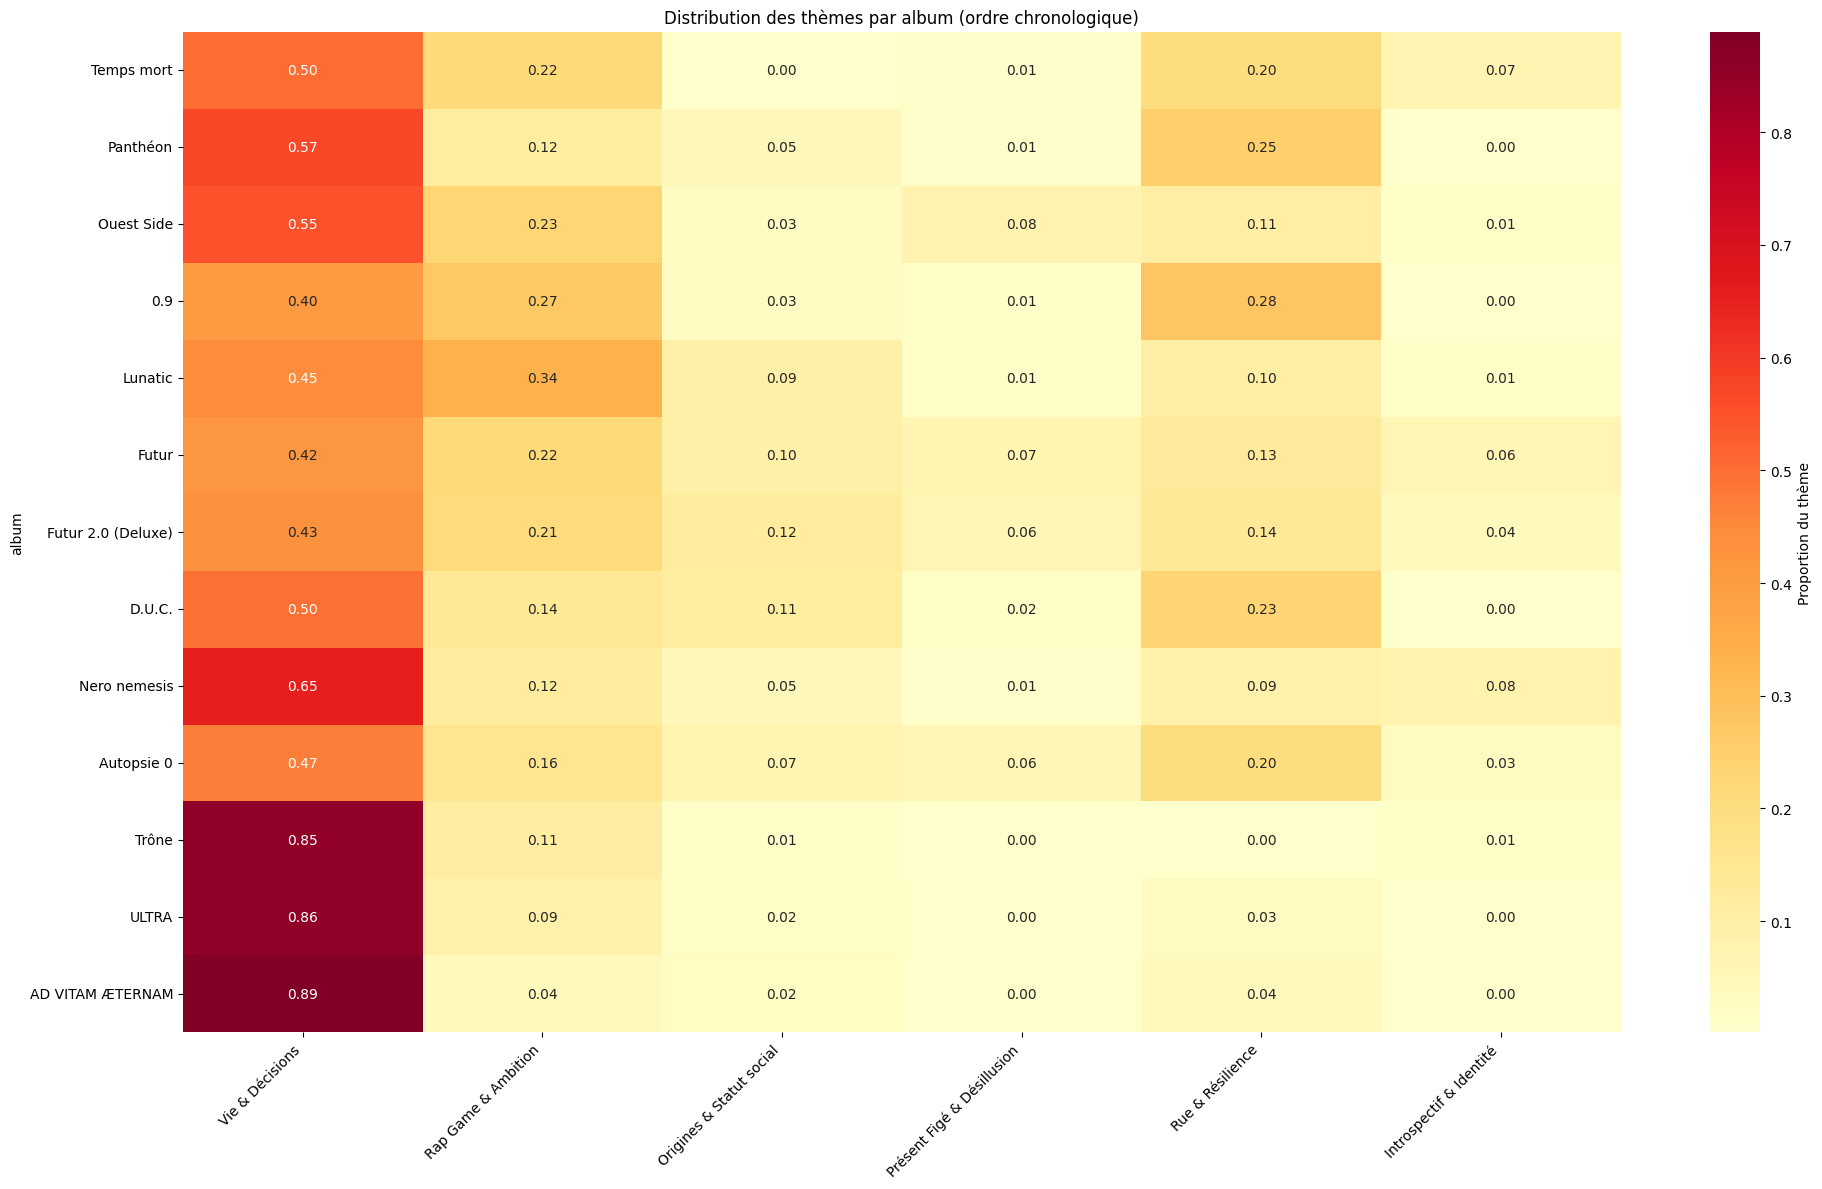

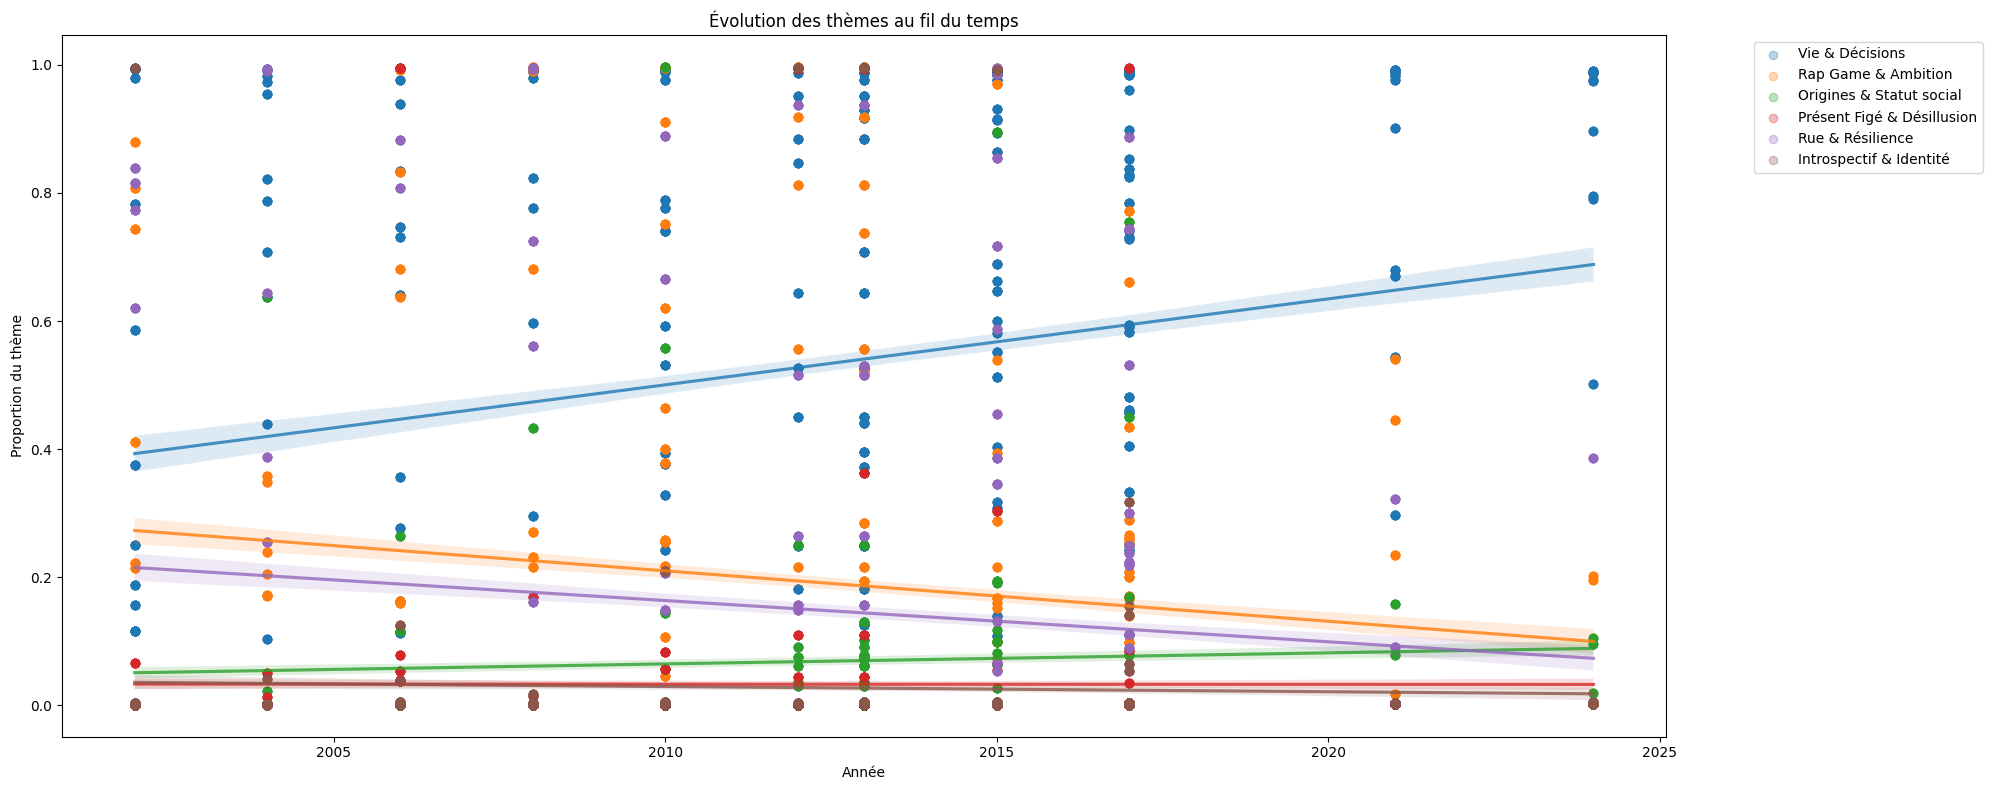

In [72]:
# Liste des noms de thèmes
noms_themes = [
    "Vie & Décisions",            # Thème 1
    "Rap Game & Ambition",        # Thème 2
    "Origines & Statut social",   # Thème 3
    "Présent Figé & Désillusion", # Thème 4
    "Rue & Résilience",           # Thème 5
    "Introspectif & Identité"     # Thème 6
]

# Création du DataFrame avec les nouveaux noms de thèmes
topic_distribution = pd.DataFrame(
    lda_output,
    columns=noms_themes  # Utilisation des noms au lieu de "Thème 1", "Thème 2", etc.
)
topic_distribution['album'] = df['album']

# Calcul des moyennes par album
topic_means = topic_distribution.groupby('album').mean()

# Création d'un dictionnaire date-album
dates_albums = df.groupby('album')['date'].min().sort_values()
topic_means_sorted = topic_means.loc[dates_albums.index]

# Création de la heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(
    topic_means_sorted,
    cmap='YlOrRd',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Proportion du thème'}
)

plt.title('Distribution des thèmes par album (ordre chronologique)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Graphique d'évolution temporelle
plt.figure(figsize=(20, 8))
for i, theme in enumerate(noms_themes):
    sns.regplot(
        data=topic_distribution.merge(df[['album', 'année']], on='album'),
        x='année',
        y=theme,  # Utilisation du nom du thème directement
        scatter=True,
        label=theme,
        scatter_kws={'alpha':0.3},
        line_kws={'alpha':0.8}
    )
plt.title('Évolution des thèmes au fil du temps')
plt.xlabel('Année')
plt.ylabel('Proportion du thème')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Richesse lexicale par album

C:\Users\yonas\AppData\Local\Temp\ipykernel_21264\3800646437.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


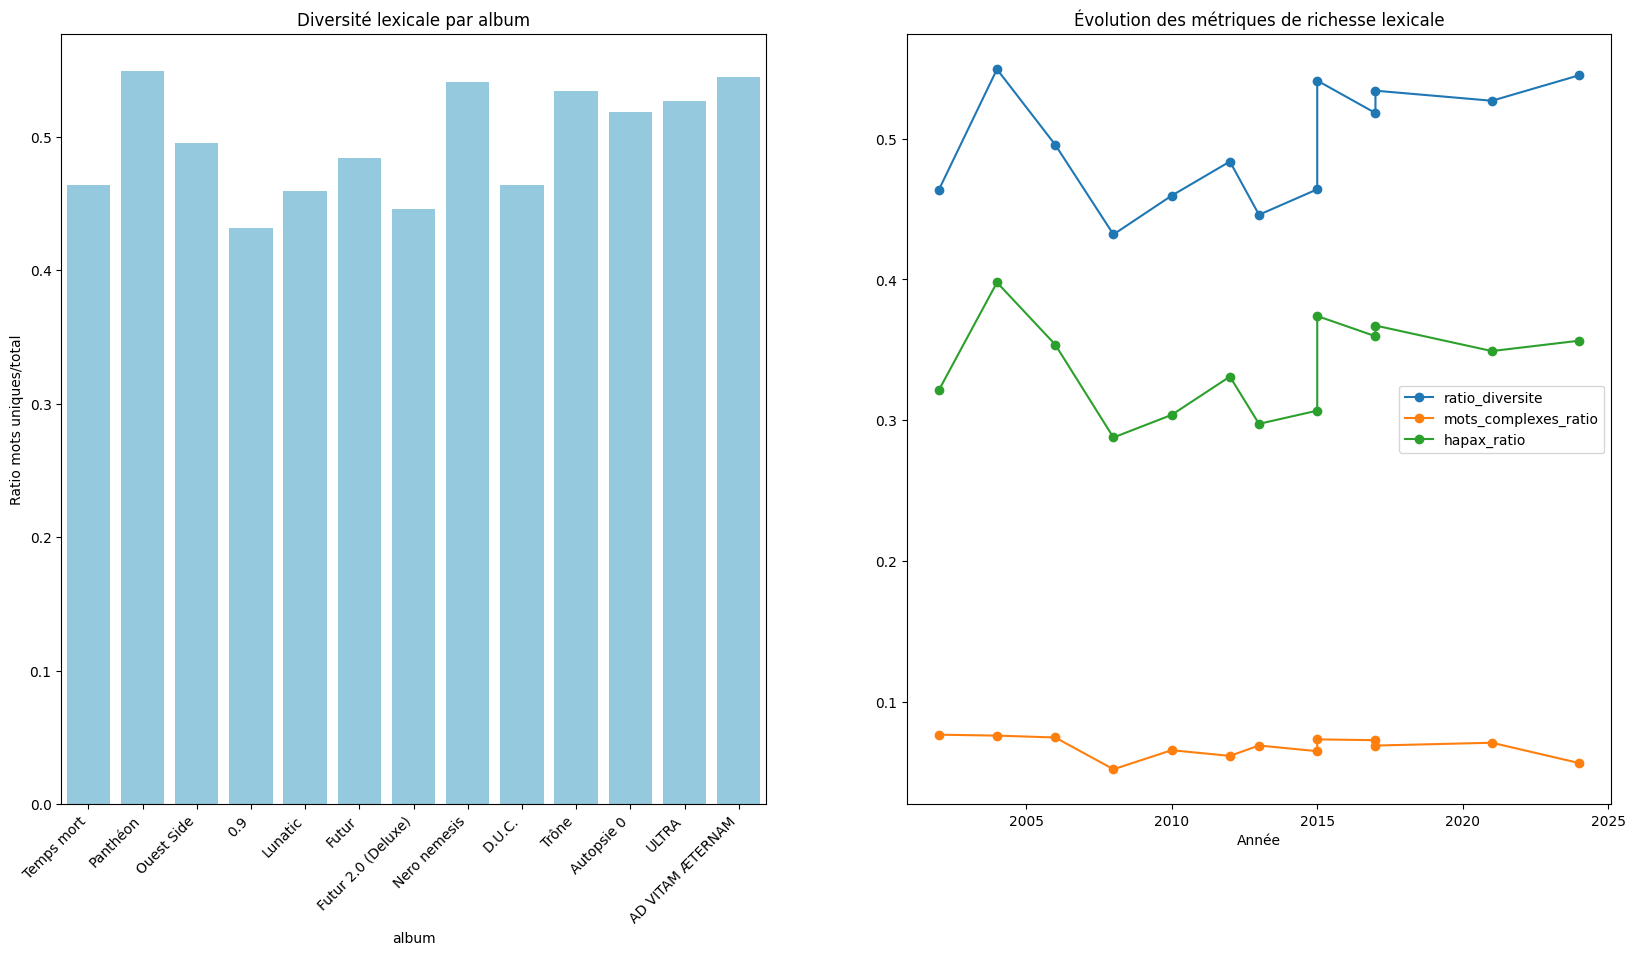

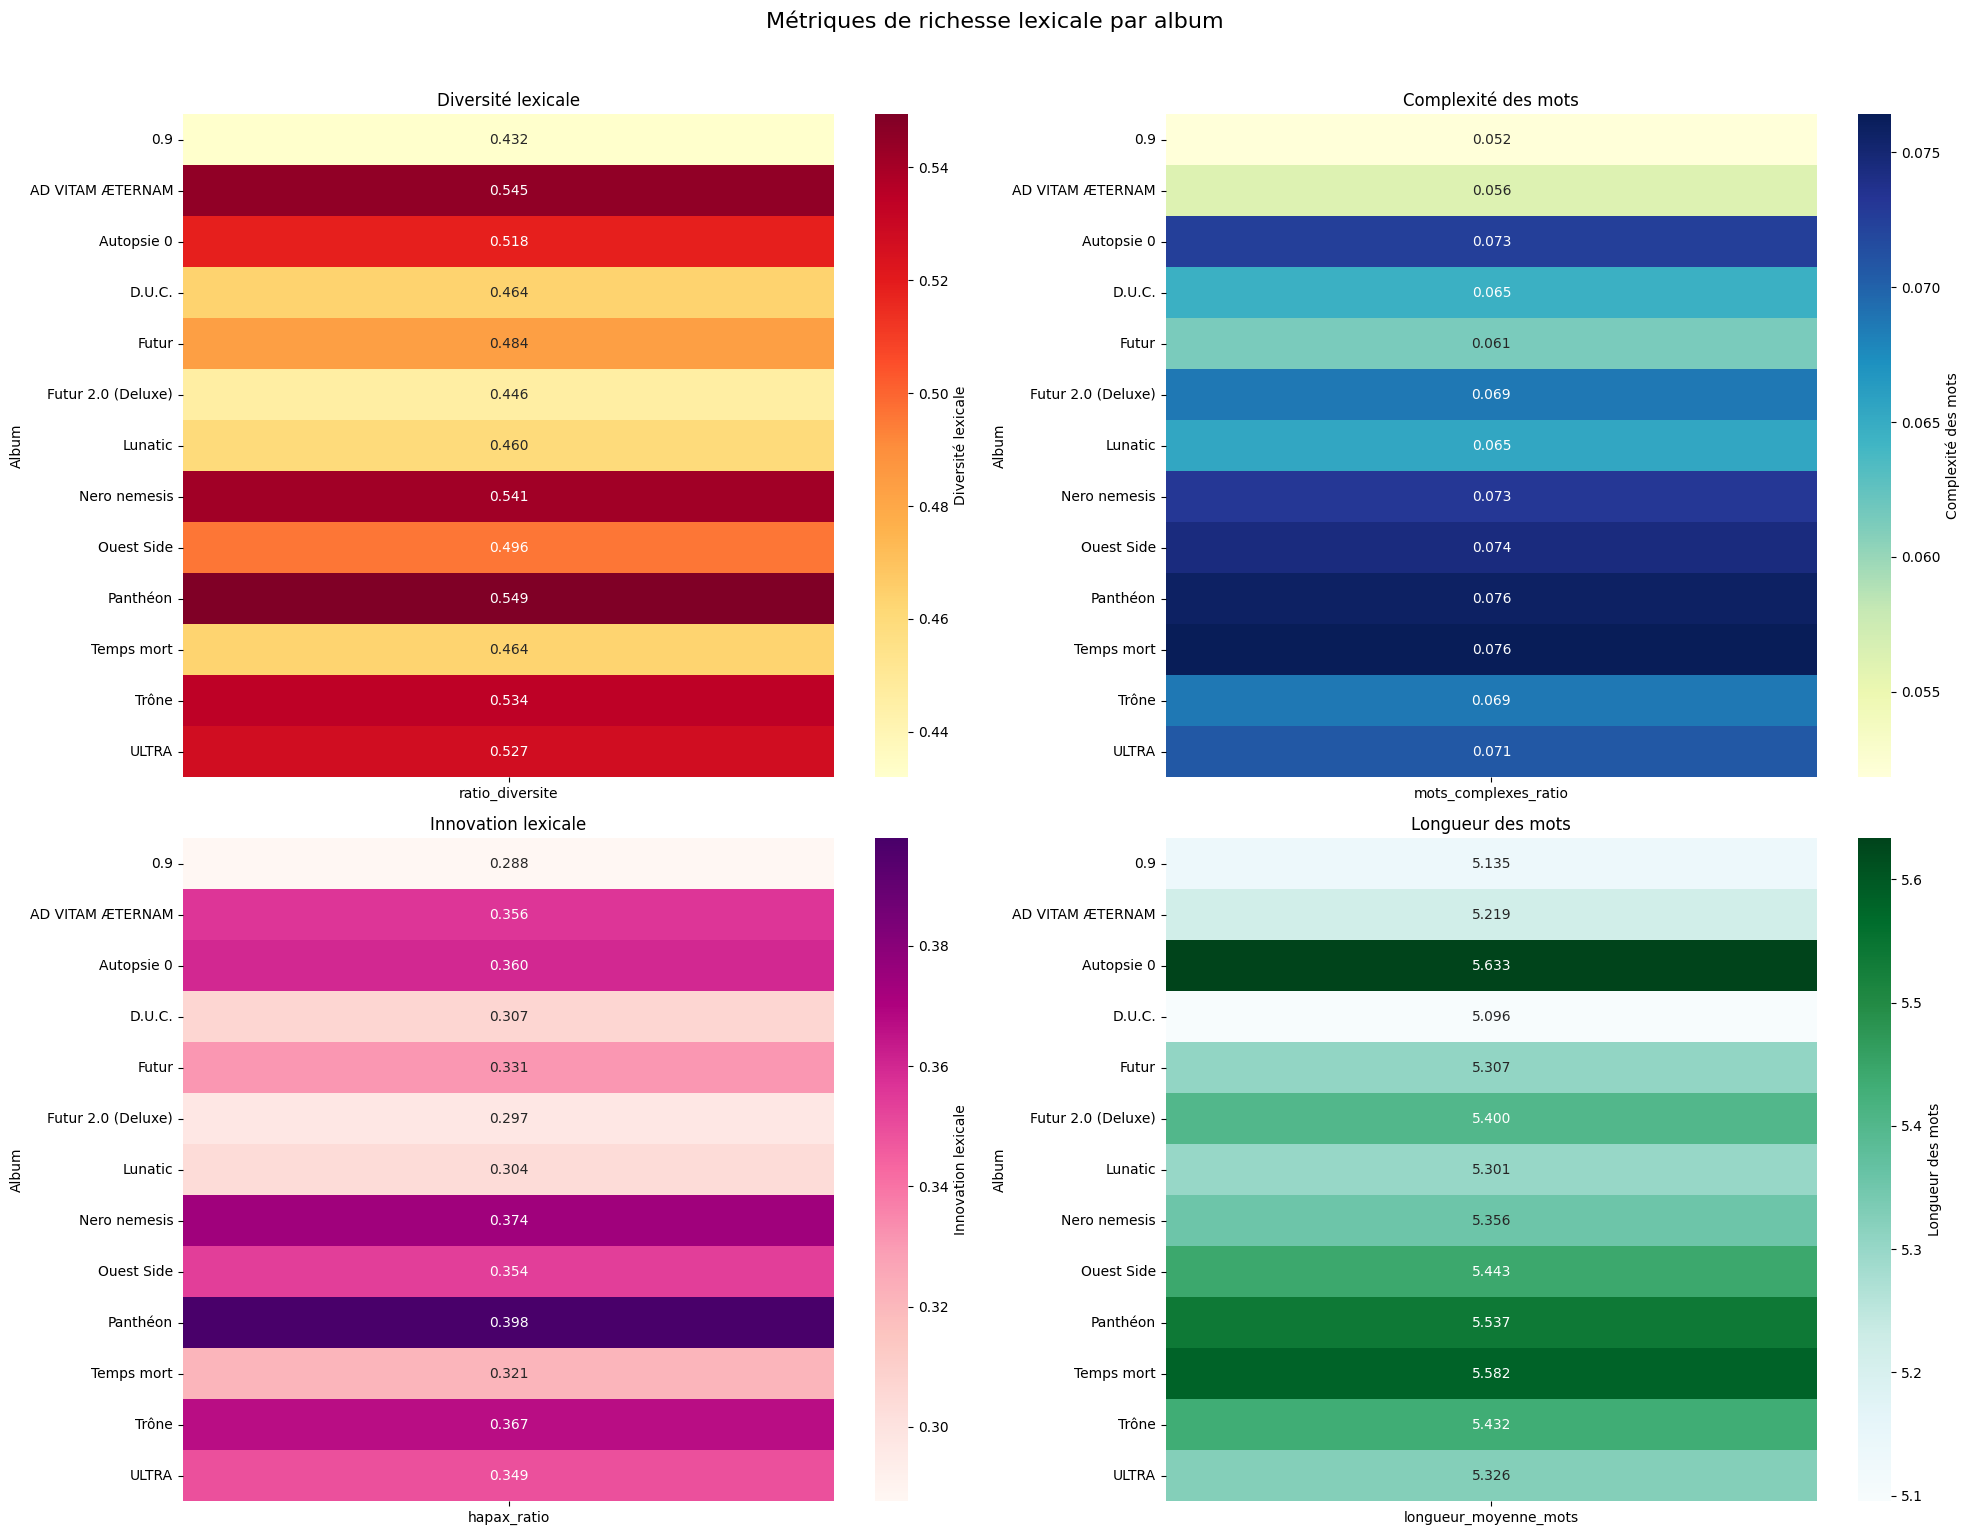


Statistiques détaillées par album:
| album              |   année |   nb_mots_total |   nb_mots_uniques |   ratio_diversite |   longueur_moyenne_mots |   hapax_ratio |
|:-------------------|--------:|----------------:|------------------:|------------------:|------------------------:|--------------:|
| Temps mort         |    2002 |            4515 |              2093 |             0.464 |                   5.582 |         0.321 |
| Panthéon           |    2004 |            3564 |              1958 |             0.549 |                   5.537 |         0.398 |
| Ouest Side         |    2006 |            4125 |              2045 |             0.496 |                   5.443 |         0.354 |
| 0.9                |    2008 |            4109 |              1775 |             0.432 |                   5.135 |         0.288 |
| Lunatic            |    2010 |            5031 |              2312 |             0.46  |                   5.301 |         0.304 |
| Futur              |    2012 | 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter

nlp = spacy.load('fr_core_news_md')

def analyser_richesse_lexicale(texte):
    if pd.isna(texte):
        return {
            'nb_mots_total': 0,
            'nb_mots_uniques': 0,
            'ratio_diversite': 0,
            'longueur_moyenne_mots': 0,
            'mots_complexes_ratio': 0,
            'hapax_ratio': 0  # mots qui n'apparaissent qu'une fois
        }
    
    doc = nlp(str(texte))
    
    # Extraction des mots (sans ponctuation et stopwords)
    mots = [token.text.lower() for token in doc 
            if token.is_alpha and not token.is_stop]
    
    if not mots:
        return {
            'nb_mots_total': 0,
            'nb_mots_uniques': 0,
            'ratio_diversite': 0,
            'longueur_moyenne_mots': 0,
            'mots_complexes_ratio': 0,
            'hapax_ratio': 0
        }
    
    # Comptage des occurrences
    freq_mots = Counter(mots)
    
    # Calculs
    nb_mots_total = len(mots)
    nb_mots_uniques = len(set(mots))
    longueur_moyenne = np.mean([len(mot) for mot in mots])
    mots_complexes = sum(1 for mot in mots if len(mot) > 8)  # mots de plus de 8 lettres
    hapax = sum(1 for mot, freq in freq_mots.items() if freq == 1)  # mots uniques
    
    return {
        'nb_mots_total': nb_mots_total,
        'nb_mots_uniques': nb_mots_uniques,
        'ratio_diversite': nb_mots_uniques / nb_mots_total,
        'longueur_moyenne_mots': longueur_moyenne,
        'mots_complexes_ratio': mots_complexes / nb_mots_total,
        'hapax_ratio': hapax / nb_mots_total
    }

# Analyse par album
resultats_albums = []
for album in df['album'].unique():
    textes_album = df[df['album'] == album]['paroles_clean']
    texte_complet = ' '.join(textes_album.fillna(''))
    metriques = analyser_richesse_lexicale(texte_complet)
    metriques['album'] = album
    metriques['année'] = df[df['album'] == album]['année'].iloc[0]
    resultats_albums.append(metriques)

df_richesse = pd.DataFrame(resultats_albums)

# Première figure : barplots et évolution
fig1 = plt.figure(figsize=(20, 10))
gs1 = fig1.add_gridspec(1, 2, wspace=0.2)

# 1. Ratio de diversité lexicale par album
ax1 = fig1.add_subplot(gs1[0, 0])
sns.barplot(data=df_richesse.sort_values('année'), 
            x='album', y='ratio_diversite',
            color='skyblue', ax=ax1)
ax1.set_title('Diversité lexicale par album')
plt.xticks(rotation=45, ha='right')
ax1.set_ylabel('Ratio mots uniques/total')

# 2. Évolution temporelle des métriques
ax2 = fig1.add_subplot(gs1[0, 1])
metrics = ['ratio_diversite', 'mots_complexes_ratio', 'hapax_ratio']
for metric in metrics:
    plt.plot(df_richesse['année'], df_richesse[metric], 
             marker='o', label=metric)
ax2.set_title('Évolution des métriques de richesse lexicale')
ax2.set_xlabel('Année')
ax2.legend()

plt.tight_layout()
plt.show()

# Deuxième figure : heatmaps séparées
fig2, axes = plt.subplots(2, 2, figsize=(20, 15))
fig2.suptitle('Métriques de richesse lexicale par album', fontsize=16, y=1.02)

metrics_mapping = {
    'ratio_diversite': ('Diversité lexicale', 'YlOrRd'),
    'mots_complexes_ratio': ('Complexité des mots', 'YlGnBu'),
    'hapax_ratio': ('Innovation lexicale', 'RdPu'),
    'longueur_moyenne_mots': ('Longueur des mots', 'BuGn')
}

for (metric, (title, cmap)), ax in zip(metrics_mapping.items(), axes.ravel()):
    data = df_richesse.pivot_table(
        index='album',
        values=[metric]
    )
    
    sns.heatmap(data, 
                annot=True, 
                fmt='.3f', 
                cmap=cmap,
                ax=ax,
                cbar_kws={'label': title})
    ax.set_title(title)
    ax.set_ylabel('Album')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

# Affichage des statistiques détaillées
print("\nStatistiques détaillées par album:")
stats_display = df_richesse.sort_values('année')[
    ['album', 'année', 'nb_mots_total', 'nb_mots_uniques', 
     'ratio_diversite', 'longueur_moyenne_mots', 'hapax_ratio']
].round(3)
print(stats_display.to_markdown(index=False))

#### Identification des signatures linguistiques

C:\Users\yonas\AppData\Local\Temp\ipykernel_21264\3713171868.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


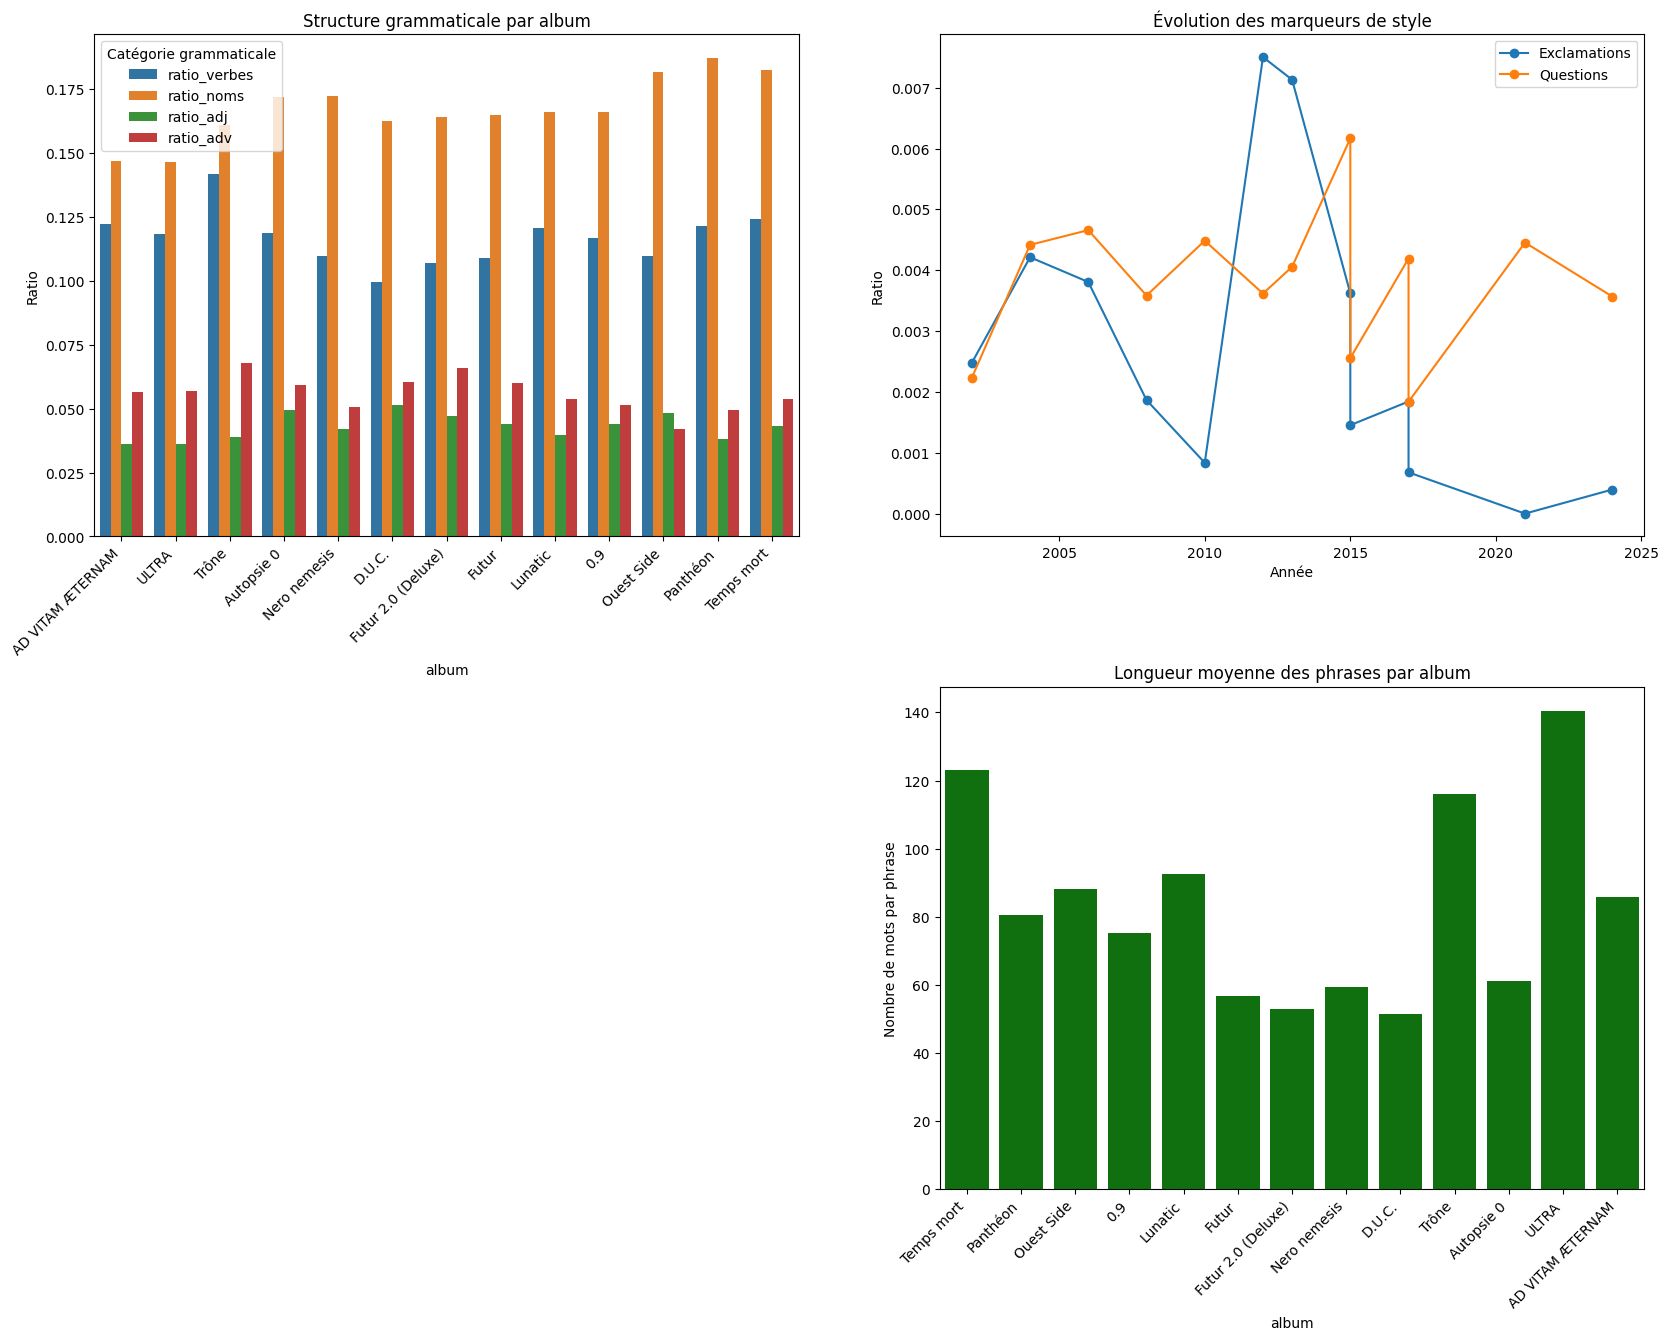


Signatures linguistiques par album:
| album              |   année |   ratio_verbes |   ratio_noms |   ratio_adj |   ratio_adv |   nb_anglicismes |   longueur_moyenne_phrases |
|:-------------------|--------:|---------------:|-------------:|------------:|------------:|-----------------:|---------------------------:|
| Temps mort         |    2002 |          0.124 |        0.182 |       0.043 |       0.054 |                0 |                    123.143 |
| Panthéon           |    2004 |          0.121 |        0.187 |       0.038 |       0.05  |                0 |                     80.454 |
| Ouest Side         |    2006 |          0.11  |        0.182 |       0.048 |       0.042 |                0 |                     88.032 |
| 0.9                |    2008 |          0.117 |        0.166 |       0.044 |       0.051 |                0 |                     75.261 |
| Lunatic            |    2010 |          0.121 |        0.166 |       0.04  |       0.054 |                0 |      

C:\Users\yonas\AppData\Local\Temp\ipykernel_21264\3713171868.py:119: RuntimeWarning: invalid value encountered in scalar divide
  change = ((recent_mean - early_mean) / early_mean) * 100


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter

nlp = spacy.load('fr_core_news_md')

def analyser_signatures_linguistiques(texte):
    if pd.isna(texte):
        return {}
    
    doc = nlp(str(texte))
    
    # 1. Structure grammaticale
    pos_counts = Counter([token.pos_ for token in doc])
    total_tokens = len([t for t in doc if not t.is_space])
    
    # 2. Anglicismes et emprunts
    anglicismes = [token.text.lower() for token in doc if token.lang_ == 'en']
    
    # 3. Ponctuation et style
    ponctuation = Counter([token.text for token in doc if token.is_punct])
    
    # 4. Longueur des phrases
    phrases = list(doc.sents)
    longueurs_phrases = [len([t for t in sent if not t.is_space]) for sent in phrases]
    
    return {
        # Ratios grammaticaux
        'ratio_verbes': pos_counts['VERB'] / total_tokens if total_tokens > 0 else 0,
        'ratio_noms': pos_counts['NOUN'] / total_tokens if total_tokens > 0 else 0,
        'ratio_adj': pos_counts['ADJ'] / total_tokens if total_tokens > 0 else 0,
        'ratio_adv': pos_counts['ADV'] / total_tokens if total_tokens > 0 else 0,
        
        # Style
        'longueur_moyenne_phrases': np.mean(longueurs_phrases) if longueurs_phrases else 0,
        'nb_anglicismes': len(anglicismes),
        'ratio_exclamations': ponctuation['!'] / total_tokens if total_tokens > 0 else 0,
        'ratio_questions': ponctuation['?'] / total_tokens if total_tokens > 0 else 0
    }

# Analyse par album
resultats = []
for album in df['album'].unique():
    textes_album = df[df['album'] == album]['paroles_clean']
    
    # Analyse pour chaque morceau de l'album
    signatures_album = []
    for texte in textes_album:
        if pd.notna(texte):
            signatures = analyser_signatures_linguistiques(texte)
            signatures_album.append(signatures)
    
    # Moyennes pour l'album
    moyennes_album = pd.DataFrame(signatures_album).mean()
    moyennes_album['album'] = album
    moyennes_album['année'] = df[df['album'] == album]['année'].iloc[0]
    
    resultats.append(moyennes_album)

df_signatures = pd.DataFrame(resultats)

# Visualisations
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 2, hspace=0.3)

# 1. Structure grammaticale par album
ax1 = fig.add_subplot(gs[0, 0])
ratios_grammaticaux = ['ratio_verbes', 'ratio_noms', 'ratio_adj', 'ratio_adv']
df_gram = df_signatures[ratios_grammaticaux + ['album']].melt(
    id_vars=['album'], 
    var_name='Catégorie', 
    value_name='Ratio'
)
sns.barplot(data=df_gram, x='album', y='Ratio', hue='Catégorie', ax=ax1)
ax1.set_title('Structure grammaticale par album')
plt.xticks(rotation=45, ha='right')
ax1.legend(title='Catégorie grammaticale')

# 2. Évolution du style
ax2 = fig.add_subplot(gs[0, 1])
style_metrics = ['ratio_exclamations', 'ratio_questions']
df_signatures.plot(x='année', y=style_metrics, marker='o', ax=ax2)
ax2.set_title('Évolution des marqueurs de style')
ax2.set_xlabel('Année')
ax2.set_ylabel('Ratio')
ax2.legend(['Exclamations', 'Questions'])



# 4. Longueur moyenne des phrases
ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(data=df_signatures.sort_values('année'),
            x='album', y='longueur_moyenne_phrases',
            color='green', ax=ax4)
ax4.set_title('Longueur moyenne des phrases par album')
plt.xticks(rotation=45, ha='right')
ax4.set_ylabel('Nombre de mots par phrase')

plt.tight_layout()
plt.show()

# Statistiques détaillées
print("\nSignatures linguistiques par album:")
stats_cols = ['album', 'année'] + ratios_grammaticaux + ['nb_anglicismes', 'longueur_moyenne_phrases']
stats_display = df_signatures[stats_cols].sort_values('année').round(3)
print(stats_display.to_markdown(index=False))

# Analyse des tendances
print("\nTendances principales:")
early_albums = df_signatures[df_signatures['année'] <= 2010]
recent_albums = df_signatures[df_signatures['année'] > 2010]

for metric in ratios_grammaticaux + ['nb_anglicismes', 'longueur_moyenne_phrases']:
    early_mean = early_albums[metric].mean()
    recent_mean = recent_albums[metric].mean()
    change = ((recent_mean - early_mean) / early_mean) * 100
    
    print(f"\n{metric}:")
    print(f"- Début de carrière: {early_mean:.3f}")
    print(f"- Période récente: {recent_mean:.3f}")
    print(f"- Évolution: {change:+.1f}%")

### Analyse structurelle

In [38]:
import re

def extract_song_structure(lyrics):
    if pd.isna(lyrics):
        return []
    
    # Nettoyer le texte initial (enlever les crédits)
    lyrics = lyrics.split('Lyrics', 1)[-1] if 'Lyrics' in lyrics else lyrics
    
    # Pattern pour détecter les sections
    pattern = r'\[(.*?)\]'
    sections = re.finditer(pattern, lyrics)
    
    structure = []
    for section in sections:
        section_name = section.group(1).lower().strip()
        
        # Gestion des cas spéciaux comme "Paroles de" ou "ft."
        if 'paroles de' in section_name or 'ft.' in section_name:
            continue
            
        if 'intro' in section_name:
            structure.append('I')
        elif 'couplet' in section_name or 'verse' in section_name:
            structure.append('C')
        elif 'refrain' in section_name or 'hook' in section_name or 'chorus' in section_name:
            structure.append('R')
        elif 'outro' in section_name or 'fin' in section_name:
            structure.append('O')
            
    return structure

# Application de la fonction sur le dataset
df['structure'] = df['paroles'].apply(extract_song_structure)
df['pattern'] = df['structure'].apply(lambda x: '-'.join(x) if x else '')

    
# Patterns les plus fréquents
print("\nPatterns les plus fréquents :")
print(df['pattern'].value_counts().head(5))


Patterns les plus fréquents :
pattern
I-C-R-C-R-C-R    33
I-C-R-C-R-O      14
C-R-C-R-C-R      12
I-C-O            11
I-C              11
Name: count, dtype: int64


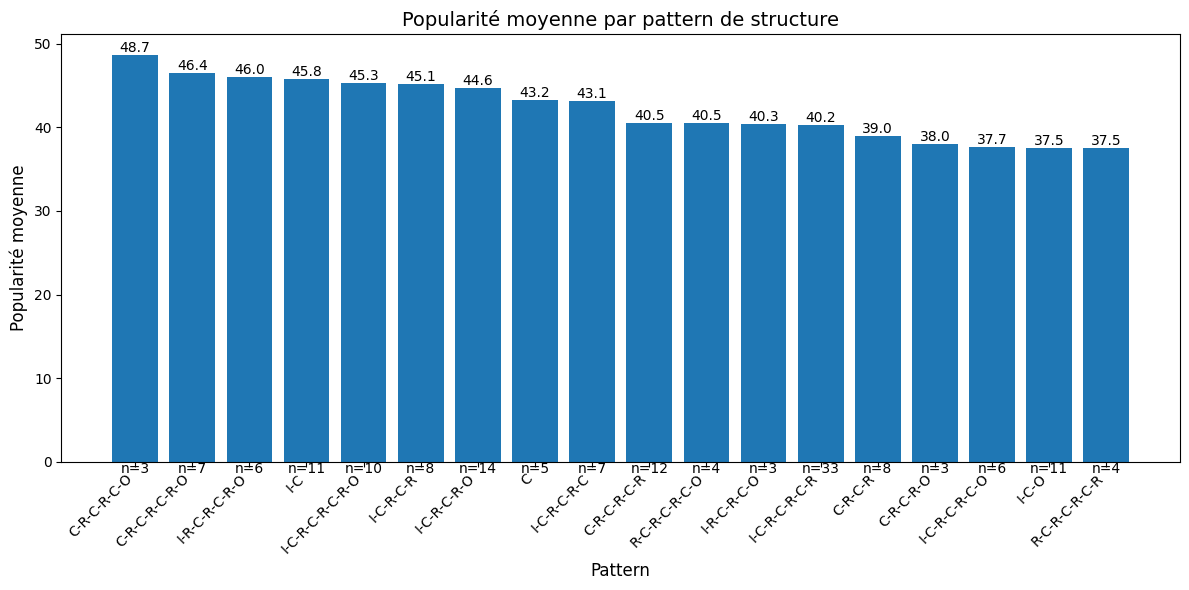


Statistiques détaillées par pattern :

Pattern | Popularité moyenne | Nombre de morceaux
--------------------------------------------------
C-R-C-R-C-O     |            48.67 |                 3
C-R-C-R-C-R-O   |            46.43 |                 7
I-R-C-R-C-R-O   |            46.00 |                 6
I-C             |            45.82 |                11
I-C-R-C-R-C-R-O |            45.30 |                10
I-C-R-C-R       |            45.12 |                 8
I-C-R-C-R-O     |            44.64 |                14
C               |            43.20 |                 5
I-C-R-C-R-C     |            43.14 |                 7
C-R-C-R-C-R     |            40.50 |                12
R-C-R-C-R-C-O   |            40.50 |                 4
I-R-C-R-C-O     |            40.33 |                 3
I-C-R-C-R-C-R   |            40.24 |                33
C-R-C-R         |            39.00 |                 8
C-R-C-R-O       |            38.00 |                 3
I-C-R-C-R-C-O   |            37.67

In [39]:
# Analyse de la popularité moyenne par pattern
pattern_popularity = df.groupby('pattern')['popularité'].agg(['mean', 'count']).round(2)
pattern_popularity = pattern_popularity[pattern_popularity['count'] >= 3]  # Filtrer les patterns avec au moins 3 morceaux
pattern_popularity = pattern_popularity.sort_values('mean', ascending=False)

# Création du graphique
plt.figure(figsize=(12, 6))
bars = plt.bar(pattern_popularity.index, pattern_popularity['mean'])

# Personnalisation
plt.title('Popularité moyenne par pattern de structure', fontsize=14)
plt.xlabel('Pattern', fontsize=12)
plt.ylabel('Popularité moyenne', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Ajout du nombre de morceaux par pattern
for i, (pattern, row) in enumerate(pattern_popularity.iterrows()):
    plt.text(i, 0, f'n={int(row["count"])}', ha='center', va='top')

plt.tight_layout()
plt.show()

# Affichage des statistiques détaillées
print("\nStatistiques détaillées par pattern :")
print("\nPattern | Popularité moyenne | Nombre de morceaux")
print("-" * 50)
for pattern, row in pattern_popularity.iterrows():
    print(f"{pattern:15} | {row['mean']:16.2f} | {int(row['count']):17}")

Top 3 des patterns par album :

AD VITAM ÆTERNAM:
- I-C-R-R-C-R-R-O: 2 morceaux (20.0%)
- I-C-O: 1 morceaux (10.0%)
- I-C-R-C-R-O: 1 morceaux (10.0%)

ULTRA:
- I-C-R-C-R-O: 3 morceaux (21.4%)
- I-R-C-R-C-R-O: 2 morceaux (14.3%)
- I-C: 1 morceaux (7.1%)

Trône:
- I-R-C-R-C-R-O: 2 morceaux (15.4%)
- I-C: 1 morceaux (7.7%)
- I-C-R-C-R: 1 morceaux (7.7%)

Autopsie 0:
- I-C-R-C-R-C-R: 3 morceaux (16.7%)
- I-C: 2 morceaux (11.1%)
- C-R-C-R-C-R: 2 morceaux (11.1%)

Nero nemesis:
- I-C: 3 morceaux (23.1%)
- I-C-R-C-R-C-R: 3 morceaux (23.1%)
- C-R-C-R-C-O: 1 morceaux (7.7%)

D.U.C.:
- I-C-R-C-R-C: 3 morceaux (15.8%)
- I-C-R-C-R-O: 3 morceaux (15.8%)
- I-C-R-C-R: 2 morceaux (10.5%)

Futur 2.0 (Deluxe):
- I-C-R-C-R-C-R: 8 morceaux (32.0%)
- I-C-O: 2 morceaux (8.0%)
- C-R-C-R-C-R: 2 morceaux (8.0%)

Futur:
- I-C-R-C-R-C-R: 5 morceaux (31.2%)
- I-C-O: 2 morceaux (12.5%)
- I-C-R-C-R-C-O: 2 morceaux (12.5%)

Lunatic:
- I-C-R-C-R-C-R: 7 morceaux (36.8%)
- I-C-R-C-R-C: 2 morceaux (10.5%)
- I-C: 1 morce

<Figure size 2000x1000 with 0 Axes>

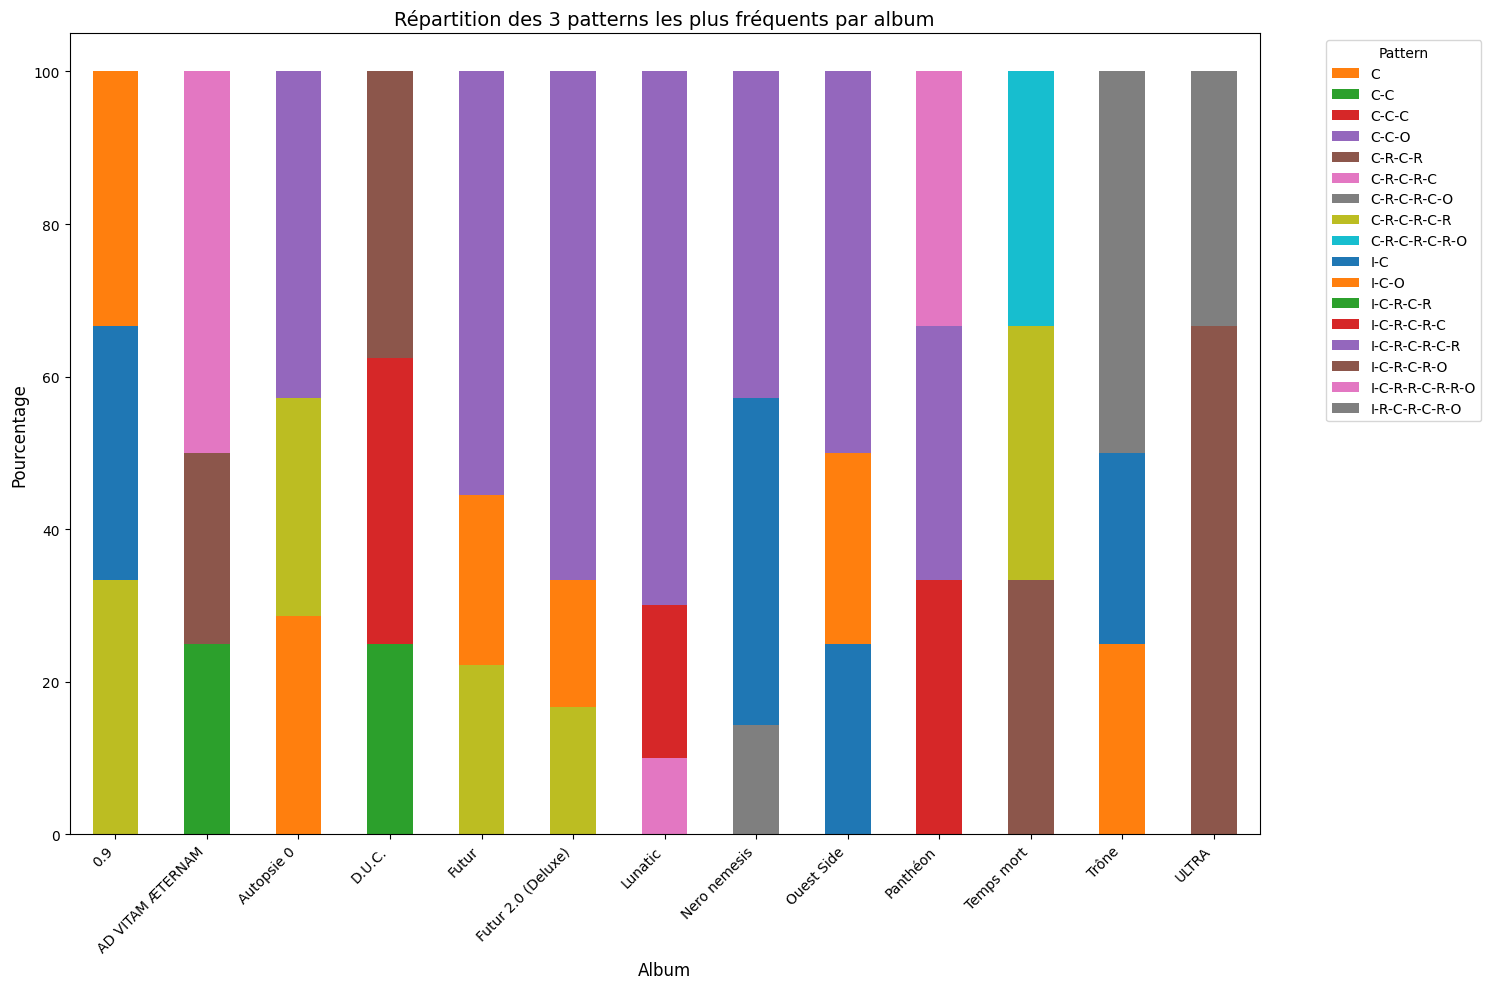

In [41]:
# Analyse des patterns par album
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Création d'un DataFrame avec les patterns par album
pattern_by_album = df.groupby(['album', 'pattern']).size().unstack(fill_value=0)

# Pour chaque album, on garde que les 3 patterns les plus fréquents
top_3_patterns = {}
for album in pattern_by_album.index:
    # Récupérer les 3 patterns les plus fréquents pour cet album
    top_3 = pattern_by_album.loc[album].nlargest(3).index.tolist()
    top_3_patterns[album] = top_3

# Créer un nouveau DataFrame avec seulement les top 3 patterns par album
pattern_by_album_filtered = pattern_by_album.copy()
for album in pattern_by_album.index:
    # Mettre à 0 tous les patterns qui ne sont pas dans le top 3 de cet album
    patterns_to_zero = [col for col in pattern_by_album.columns if col not in top_3_patterns[album]]
    pattern_by_album_filtered.loc[album, patterns_to_zero] = 0

# Supprimer les colonnes qui ne sont que des zéros
pattern_by_album_filtered = pattern_by_album_filtered.loc[:, (pattern_by_album_filtered != 0).any(axis=0)]

# Calcul des pourcentages
pattern_by_album_pct = pattern_by_album_filtered.div(pattern_by_album_filtered.sum(axis=1), axis=0) * 100

# Création de la visualisation
plt.figure(figsize=(20, 10))
ax = pattern_by_album_pct.plot(kind='bar', stacked=True)

plt.title('Répartition des 3 patterns les plus fréquents par album', fontsize=14)
plt.xlabel('Album', fontsize=12)
plt.ylabel('Pourcentage', fontsize=12)
plt.legend(title='Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Affichage des statistiques détaillées
print("Top 3 des patterns par album :")
for album in df['album'].unique():
    print(f"\n{album}:")
    album_patterns = df[df['album'] == album]['pattern'].value_counts()
    total_songs = len(df[df['album'] == album])
    
    # Afficher les 3 patterns les plus fréquents
    for pattern, count in album_patterns.head(3).items():
        percentage = (count/total_songs) * 100
        print(f"- {pattern}: {count} morceaux ({percentage:.1f}%)")

Patterns dominants par année :

2002:
- I-C-O: 2 morceaux (11.8%)
- C-R-C-R-C-R: 2 morceaux (11.8%)
- C-R-C-R: 2 morceaux (11.8%)

2004:
- I-C-O: 1 morceaux (7.7%)
- C-C-O: 1 morceaux (7.7%)
- I-C-C-R-C-C-R-O: 1 morceaux (7.7%)

2006:
- I-C-R-C-R-C-R: 2 morceaux (12.5%)
- C: 1 morceaux (6.2%)
- I-C-R-C-R-C: 1 morceaux (6.2%)

2008:
- I-C-O: 2 morceaux (12.5%)
- I-C: 2 morceaux (12.5%)
- C-R-C-R-C-R: 2 morceaux (12.5%)

2010:
- I-C-R-C-R-C-R: 7 morceaux (36.8%)
- I-C-R-C-R-C: 2 morceaux (10.5%)
- I-C: 1 morceaux (5.3%)

2012:
- I-C-R-C-R-C-R: 5 morceaux (31.2%)
- I-C-O: 2 morceaux (12.5%)
- I-C-R-C-R-C-O: 2 morceaux (12.5%)

2013:
- I-C-R-C-R-C-R: 8 morceaux (32.0%)
- I-C-O: 2 morceaux (8.0%)
- C-R-C-R-C-R: 2 morceaux (8.0%)

2015:
- I-C-R-C-R-O: 4 morceaux (12.5%)
- I-C-R-C-R-C-R: 4 morceaux (12.5%)
- I-C-R-C-R-C: 3 morceaux (9.4%)

2017:
- I-C-R-C-R-C-R: 4 morceaux (12.9%)
- I-C: 3 morceaux (9.7%)
- C: 3 morceaux (9.7%)

2021:
- I-C-R-C-R-O: 3 morceaux (21.4%)
- I-R-C-R-C-R-O: 2 morce

<Figure size 2000x1000 with 0 Axes>

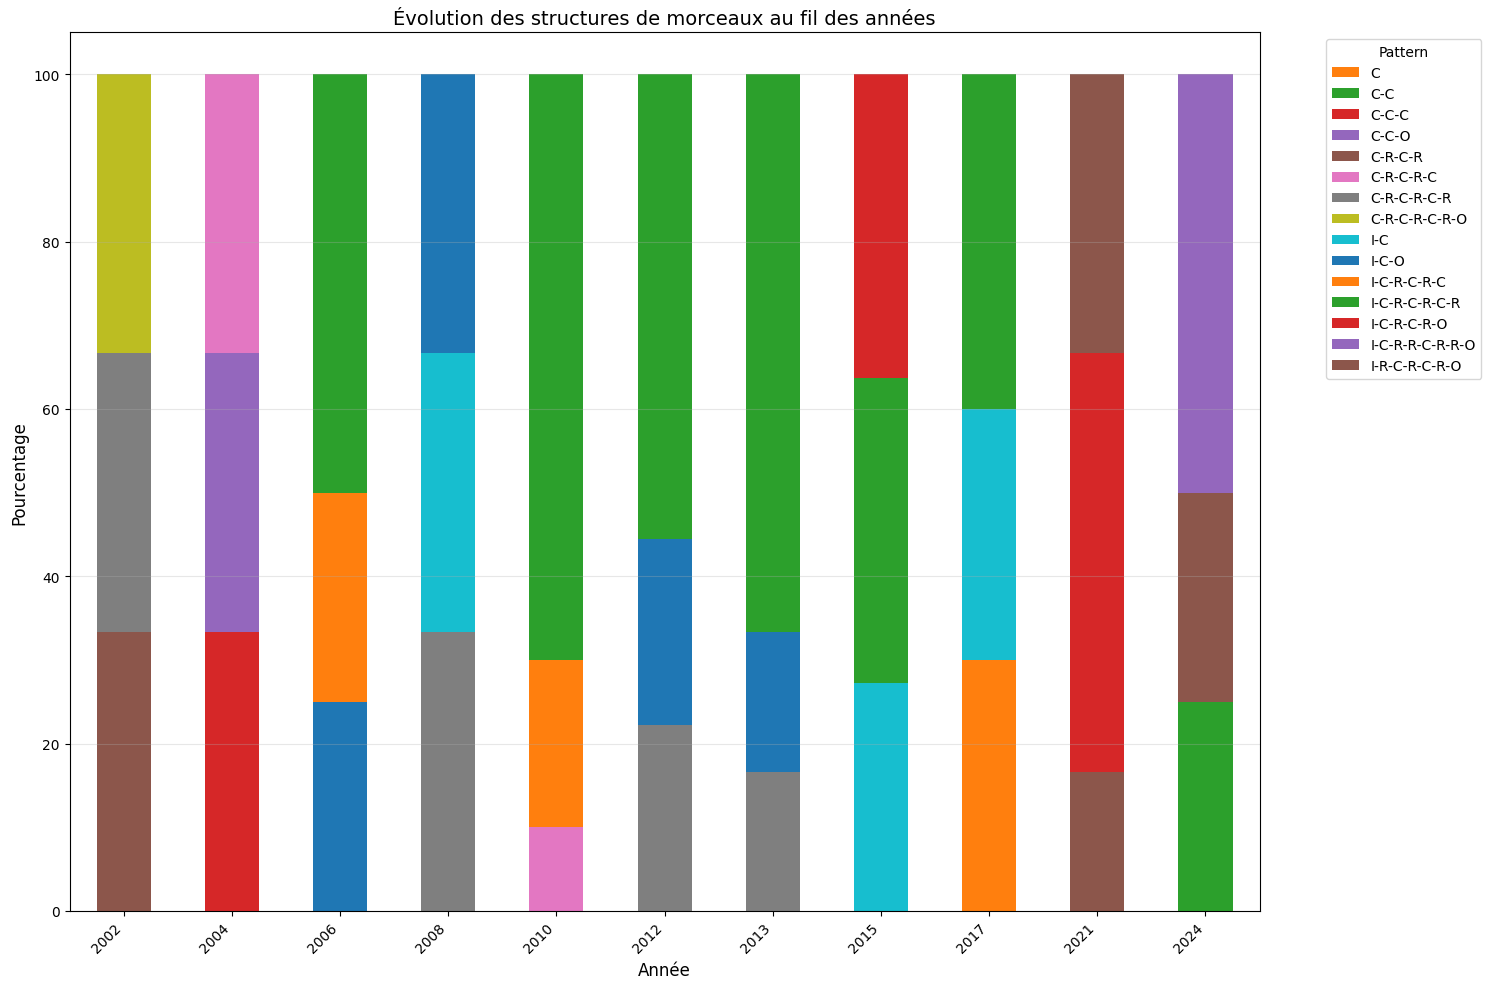

In [43]:
# Analyse de la relation entre structure et période
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conversion de la date en année
df['année'] = pd.to_datetime(df['date']).dt.year

# Création d'un DataFrame avec les patterns par année
pattern_by_year = df.groupby(['année', 'pattern']).size().unstack(fill_value=0)

# Pour chaque année, on garde que les 3 patterns les plus fréquents
top_3_patterns = {}
for année in pattern_by_year.index:
    top_3 = pattern_by_year.loc[année].nlargest(3).index.tolist()
    top_3_patterns[année] = top_3

# Filtrer pour ne garder que les top 3 patterns par année
pattern_by_year_filtered = pattern_by_year.copy()
for année in pattern_by_year.index:
    patterns_to_zero = [col for col in pattern_by_year.columns if col not in top_3_patterns[année]]
    pattern_by_year_filtered.loc[année, patterns_to_zero] = 0

# Supprimer les colonnes qui ne sont que des zéros
pattern_by_year_filtered = pattern_by_year_filtered.loc[:, (pattern_by_year_filtered != 0).any(axis=0)]

# Calcul des pourcentages
pattern_by_year_pct = pattern_by_year_filtered.div(pattern_by_year_filtered.sum(axis=1), axis=0) * 100

# Création de la visualisation
plt.figure(figsize=(20, 10))
ax = pattern_by_year_pct.plot(kind='bar', stacked=True)

plt.title('Évolution des structures de morceaux au fil des années', fontsize=14)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Pourcentage', fontsize=12)
plt.legend(title='Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Affichage des statistiques détaillées
print("Patterns dominants par année :")
for année in sorted(df['année'].unique()):
    print(f"\n{année}:")
    year_patterns = df[df['année'] == année]['pattern'].value_counts()
    total_songs = len(df[df['année'] == année])
    
    # Afficher les 3 patterns les plus fréquents
    for pattern, count in year_patterns.head(3).items():
        percentage = (count/total_songs) * 100
        print(f"- {pattern}: {count} morceaux ({percentage:.1f}%)")

# Calcul des tendances
print("\nÉvolution des patterns au fil du temps:")
earliest_year = df['année'].min()
latest_year = df['année'].max()
print(f"\nComparaison entre {earliest_year} et {latest_year}:")

early_patterns = df[df['année'] == earliest_year]['pattern'].value_counts().head(3)
recent_patterns = df[df['année'] == latest_year]['pattern'].value_counts().head(3)

print(f"\nPatterns dominants en {earliest_year}:")
for pattern, count in early_patterns.items():
    print(f"- {pattern}: {count} morceaux")

print(f"\nPatterns dominants en {latest_year}:")
for pattern, count in recent_patterns.items():
    print(f"- {pattern}: {count} morceaux")

C:\Users\yonas\AppData\Local\Temp\ipykernel_21264\3891569431.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duree_stats = df.groupby('période').agg({


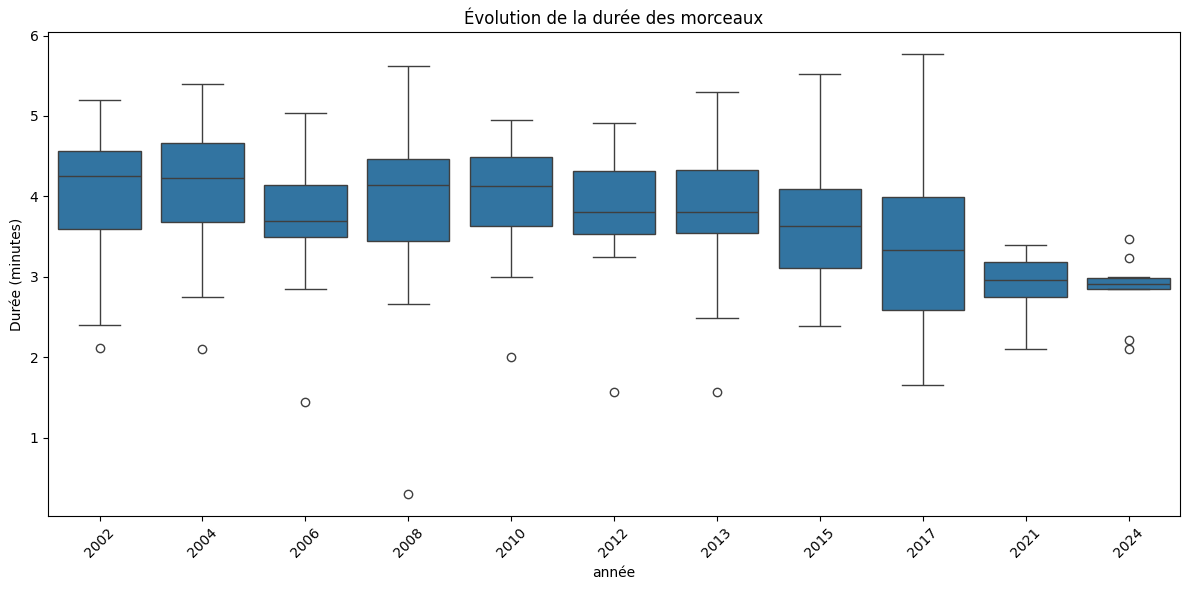


Statistiques de durée par période:
| période   |   Moyenne |   Écart-type |   Minimum |   Maximum |
|:----------|----------:|-------------:|----------:|----------:|
| Début     |      3.93 |         0.91 |      0.3  |      5.62 |
| Milieu    |      3.77 |         0.75 |      1.57 |      5.52 |
| Récent    |      3.2  |         0.85 |      1.65 |      5.77 |

Tendances de durée:
Durée moyenne avant 2010: 3.93 minutes
Durée moyenne après 2010: 3.52 minutes
Évolution: -10.3%


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des statistiques de durée
duree_stats = df.groupby('période').agg({
    'durée_min': ['mean', 'std', 'min', 'max']
}).round(2)
duree_stats.columns = ['Moyenne', 'Écart-type', 'Minimum', 'Maximum']

# Visualisation
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='année', y='durée_min')
plt.title('Évolution de la durée des morceaux')
plt.xlabel('année')
plt.ylabel('Durée (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Affichage des statistiques de durée
print("\nStatistiques de durée par période:")
print(duree_stats.to_markdown())

# Calcul des tendances
print("\nTendances de durée:")
early_period = df[df['année'] <= 2010]['durée_min'].mean()
late_period = df[df['année'] > 2010]['durée_min'].mean()
change = ((late_period - early_period) / early_period) * 100
print(f"Durée moyenne avant 2010: {early_period:.2f} minutes")
print(f"Durée moyenne après 2010: {late_period:.2f} minutes")
print(f"Évolution: {change:+.1f}%")

**Évolution de la construction des morceaux** :

- Montre l'évolution du nombre de couplets, refrains, et la présence d'intro/outro par période

**Patterns de composition par période :**

- Affiche les 3 structures les plus communes pour chaque période
- Utilise un système de notation où I=Intro, C=Couplet, R=Refrain, O=Outro

**Relation entre structure et période :**

- Heatmap montrant la relation entre différents aspects structurels et les périodes
- Inclut le nombre de parties, la durée, les couplets et les refrains

**Évolution de la durée des morceaux :**

- Boxplot montrant la distribution des durées par période
- Permet de voir l'évolution et la variabilité des durées

### Analyse des collaborations

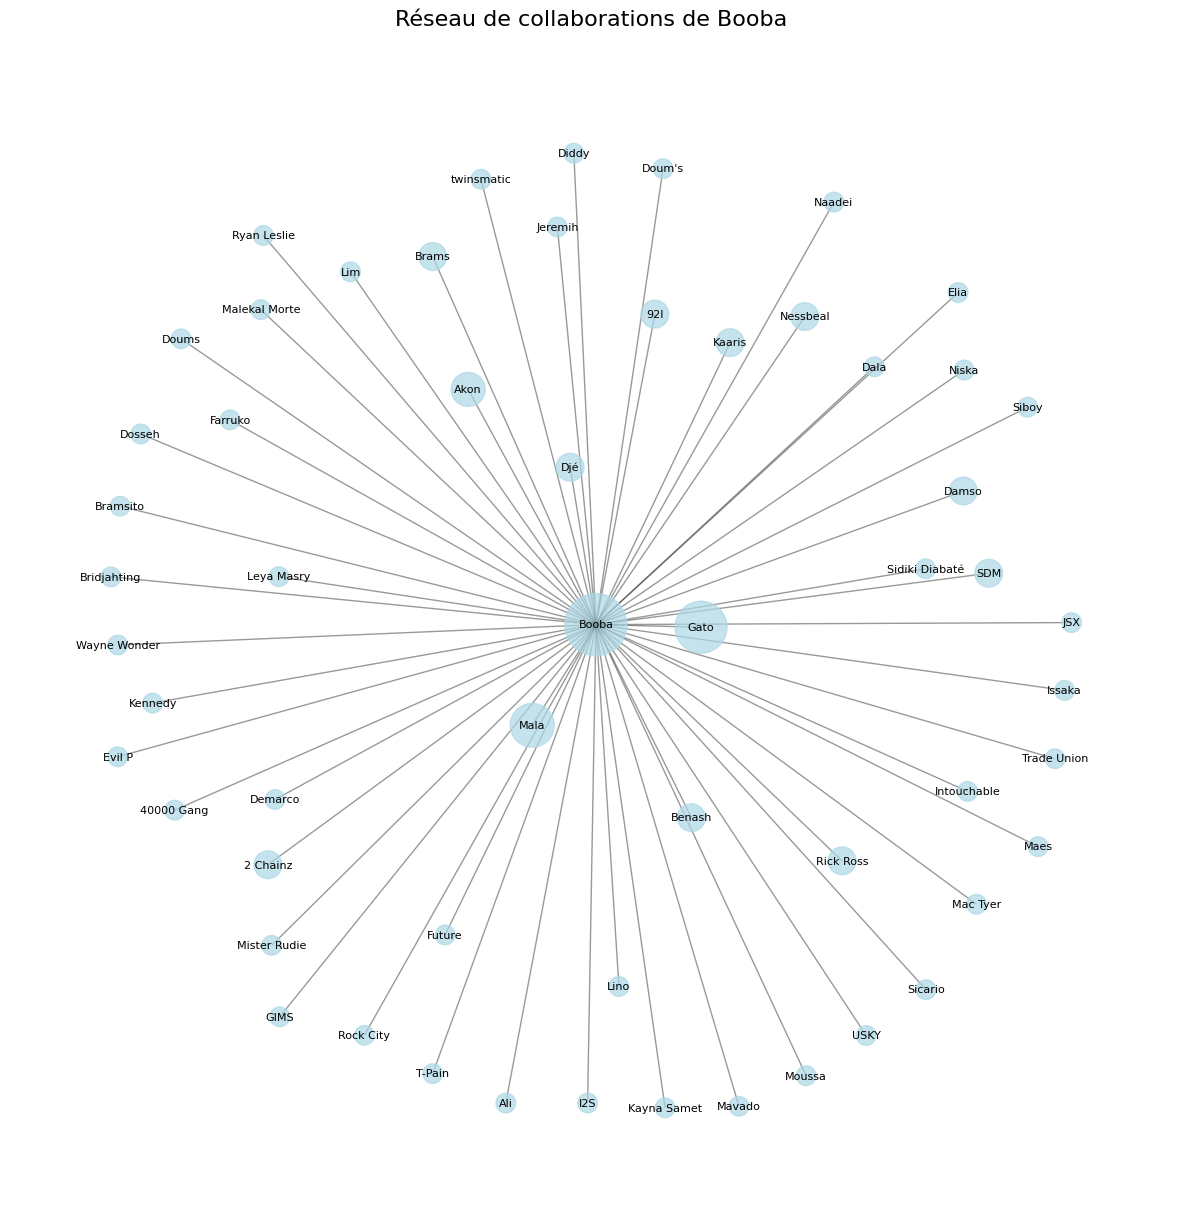

In [45]:
import networkx as nx

def create_collaboration_network():
    # Créer un dictionnaire pour compter les collaborations
    collaborations = {}
    
    # Parcourir chaque ligne du DataFrame
    for _, row in df.iterrows():
        artists = row['artistes'].split(', ')
        if len(artists) > 1:  # S'il y a des featuring
            for artist in artists:
                if artist != 'Booba':
                    if artist in collaborations:
                        collaborations[artist] += 1
                    else:
                        collaborations[artist] = 1
    
    # Créer le graphe
    G = nx.Graph()
    G.add_node('Booba', size=2000)  # Nœud central
    
    # Ajouter les collaborateurs
    for artist, count in collaborations.items():
        G.add_node(artist, size=count * 200)
        G.add_edge('Booba', artist, weight=count)
    
    # Création de la visualisation
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Dessiner les nœuds
    sizes = [G.nodes[node]['size'] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Réseau de collaborations de Booba", fontsize=16, pad=20)
    plt.axis('off')
    plt.show()

create_collaboration_network()

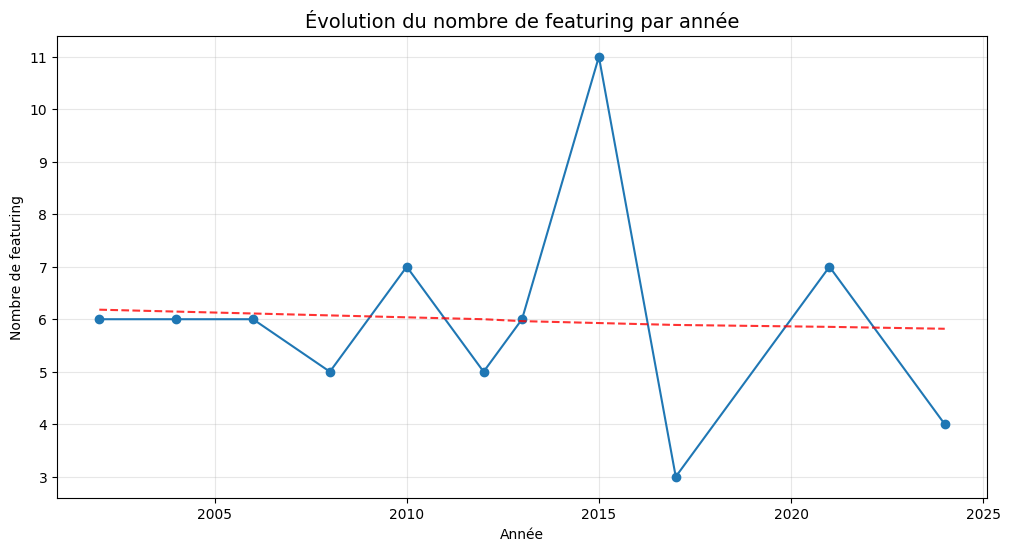

In [31]:


# Nouvelle cellule pour l'évolution des featuring par année
def plot_featuring_evolution():
    # Convertir les dates en datetime
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    
    # Compter le nombre de featuring par année
    featuring_counts = df[df['artistes'].str.contains(',')].groupby('year').size()
    
    # Créer le graphique
    plt.figure(figsize=(12, 6))
    featuring_counts.plot(kind='line', marker='o')
    
    # Ajouter une ligne de tendance
    z = np.polyfit(range(len(featuring_counts)), featuring_counts, 1)
    p = np.poly1d(z)
    plt.plot(featuring_counts.index, p(range(len(featuring_counts))), "r--", alpha=0.8)
    
    plt.title("Évolution du nombre de featuring par année", fontsize=14)
    plt.xlabel("Année")
    plt.ylabel("Nombre de featuring")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_featuring_evolution()

In [55]:
df.featuring_artistes.unique()    

array([nan, ' SDM', ' Evil P,  Gato', ' Sicario', ' USKY', ' JSX',
       ' Dala', ' Maes', ' Gato', ' Elia', ' Bramsito',
       ' Niska,  Sidiki Diabaté', ' Damso', ' Siboy,  Benash', ' Benash',
       ' twinsmatic', ' Damso,  Gato', ' Future', ' Jeremih',
       ' 40000 Gang', ' Bridjahting,  Gato', ' Farruko', ' Mavado',
       ' Lino', ' 2 Chainz', ' Kaaris', ' Rick Ross', ' Mala', ' GIMS',
       ' Diddy', ' Akon', ' 92I', ' Dosseh', ' T-Pain', ' Djé',
       ' Ryan Leslie', ' Akon,  92I', ' Rock City', ' Demarco', ' Naadei',
       ' Malekal Morte', ' Mac Tyer', ' Kennedy',
       ' Trade Union,  Mister Rudie', ' Intouchable', " Doum's",
       ' Nessbeal', ' Wayne Wonder', ' I2S,  Brams', ' Leya Masry',
       ' Lim,  Moussa', ' Mala,  Brams,  Doums,  Issaka', ' Ali',
       ' Kayna Samet'], dtype=object)

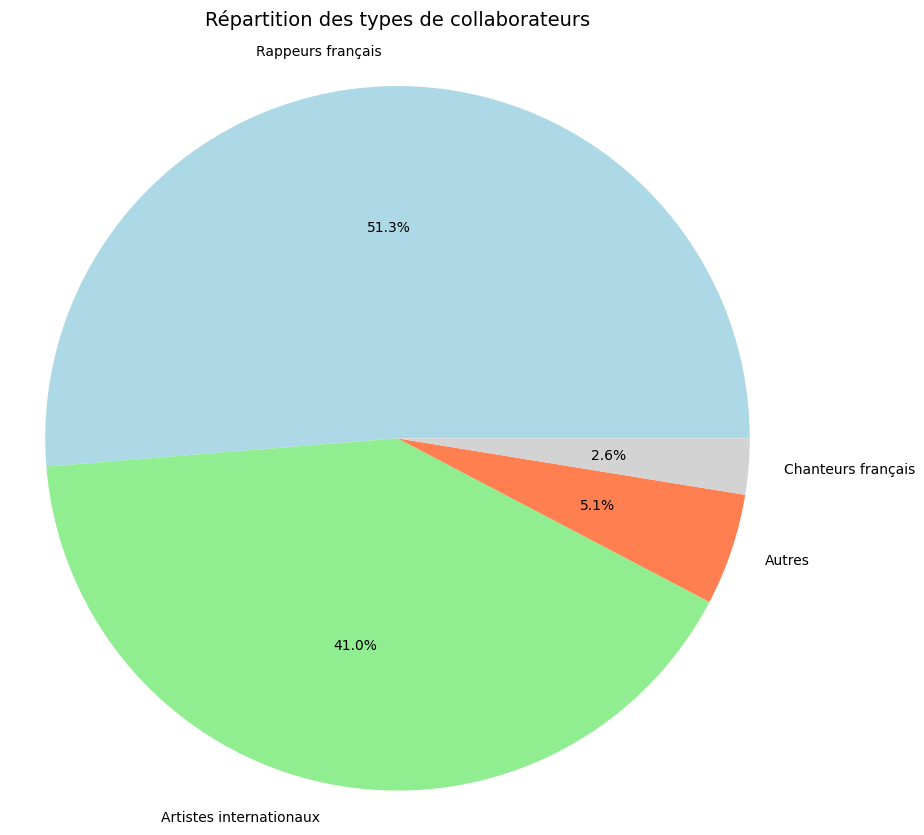

In [59]:


# Nouvelle cellule pour les types de collaborateurs
def plot_collaborator_types():
    # Définition des artistes par catégorie (exemple simplifié)
    rappeurs_fr = [
    'SDM',  'Sicario', 'JSX', 'Dala', 'Maes', 'Elia',
    'Bramsito', 'Niska', 'Sidiki Diabaté', 'Damso', 'Benash',
    'Siboy', 'Mala', '92I', 'Dosseh', 'Djé', 'Brams', 'Mala',
    'Doums', 'Issaka', 'Ali', 'Lino', 'Mac Tyer', 'Kennedy',
    'Intouchable', "Doum's", 'Nessbeal', 'Lim', 'Moussa','USKY'
    ]

    chanteurs_fr = [
        'Sidiki Diabaté', 'Kayna Samet', 'Elia', 'Bramsito','GIMS'
    ]

    international = [
        'Evil P',  'twinsmatic', 'Future', 'Jeremih',
    '40000 Gang', 'Bridjahting', 'Farruko', 'Mavado',
    '2 Chainz', 'Rick Ross',  'Diddy', 'Akon',
    'T-Pain', 'Ryan Leslie', 'Rock City', 'Demarco',
    'Naadei', 'Trade Union', 'Mister Rudie', 'Wayne Wonder',
    'Leya Masry','Gato'
    ]
    
    # Fonction pour classifier les artistes
    def get_artist_type(artist):
        if artist in rappeurs_fr:
            return 'Rappeurs français'
        elif artist in chanteurs_fr:
            return 'Chanteurs français'
        elif artist in international:
            return 'Artistes internationaux'
        else:
            return 'Autres'
    
    # Collecter tous les featuring
    collaborators = []
    for artists in df['artistes']:
        artists_list = artists.split(', ')
        collaborators.extend([a for a in artists_list if a != 'Booba'])
    
    # Classifier les artistes
    artist_types = [get_artist_type(artist) for artist in collaborators]
    type_counts = pd.Series(artist_types).value_counts()
    
    # Créer le pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', 
            colors=['lightblue', 'lightgreen', 'coral', 'lightgray'])
    plt.title("Répartition des types de collaborateurs", fontsize=14, pad=20)
    plt.axis('equal')
    plt.show()

plot_collaborator_types()

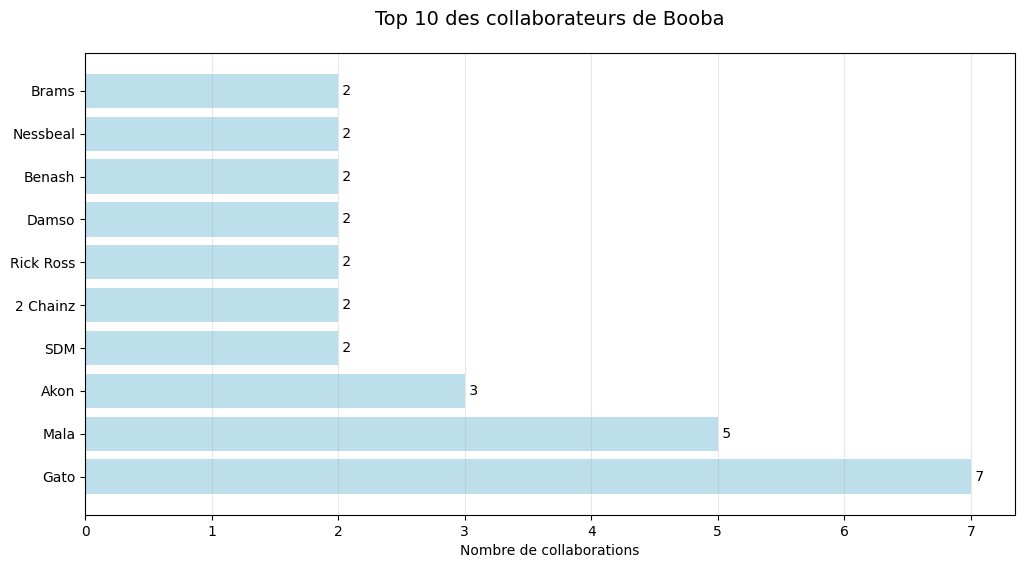

In [60]:

# Nouvelle cellule pour le top des collaborateurs
def plot_top_collaborators():
    # Compter les collaborations par artiste
    collaborators = []
    for artists in df['artistes']:
        artists_list = artists.split(', ')
        collaborators.extend([a for a in artists_list if a != 'Booba'])
    
    # Créer un DataFrame des collaborations
    collab_counts = pd.Series(collaborators).value_counts()
    top_10_collabs = collab_counts.head(10)
    
    # Créer le graphique à barres horizontales
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(top_10_collabs)), top_10_collabs.values, 
                    color='lightblue', alpha=0.8)
    
    # Ajouter les labels
    plt.yticks(range(len(top_10_collabs)), top_10_collabs.index)
    plt.xlabel("Nombre de collaborations")
    plt.title("Top 10 des collaborateurs de Booba", fontsize=14, pad=20)
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(top_10_collabs.values):
        plt.text(v, i, f' {v}', va='center')
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.show()

plot_top_collaborators()

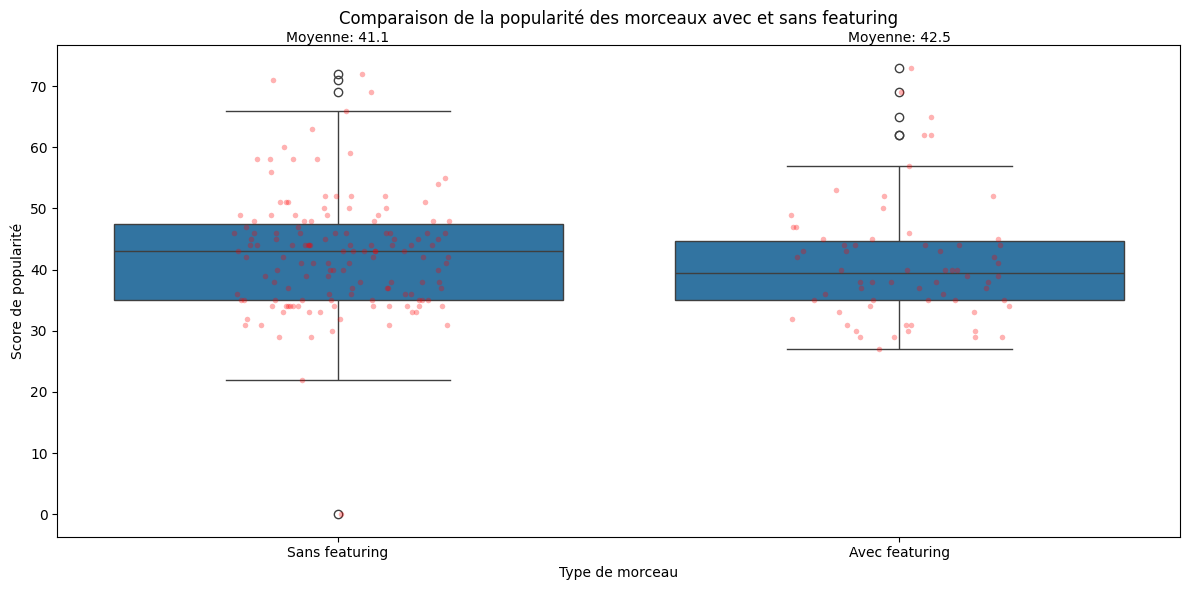


Statistiques détaillées:
                count   mean   std  min  max
has_feat                                    
Avec featuring     66  41.08  9.87   27   73
Sans featuring    143  42.50  9.45    0   72


In [63]:
# Création d'une colonne pour identifier les featurings
df['has_feat'] = df['artistes'].apply(lambda x: 'Avec featuring' if ',' in x else 'Sans featuring')

# Création du graphique
plt.figure(figsize=(12, 6))

# Utilisation de seaborn pour un boxplot
sns.boxplot(x='has_feat', y='popularité', data=df)

# Ajout des points individuels avec jitter
sns.stripplot(x='has_feat', y='popularité', data=df, color='red', alpha=0.3, jitter=0.2, size=4)

# Personnalisation
plt.title('Comparaison de la popularité des morceaux avec et sans featuring', fontsize=12, pad=15)
plt.xlabel('Type de morceau', fontsize=10)
plt.ylabel('Score de popularité', fontsize=10)

# Ajout des moyennes
means = df.groupby('has_feat')['popularité'].mean()
for i, mean in enumerate(means):
    plt.text(i, plt.ylim()[1], f'Moyenne: {mean:.1f}', 
             horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

# Affichage des statistiques
print("\nStatistiques détaillées:")
print(df.groupby('has_feat')['popularité'].agg(['count', 'mean', 'std', 'min', 'max']).round(2))



 Analyse des Visualisations

 1. Réseau de Collaboration

Ce graphique représente visuellement l'écosystème des collaborations de Booba. Au centre se trouve Booba, et autour de lui sont disposés tous ses collaborateurs. La taille des nœuds est proportionnelle au nombre de collaborations avec chaque artiste, ce qui permet d'identifier rapidement ses collaborateurs les plus fréquents.

 2. Évolution des Featuring par Année

Cette visualisation montre comment le nombre de collaborations de Booba a évolué au fil du temps. La ligne rouge en pointillés représente la tendance générale, permettant de voir si Booba collabore plus ou moins qu'avant. Les pics indiquent les années particulièrement riches en collaborations.

 3. Types de Collaborateurs

Le diagramme circulaire offre une vue d'ensemble de la diversité des collaborations de Booba. Il montre la répartition entre :
- Rappeurs français : ses collaborations principales dans le rap game français
- Chanteurs français : ses ouvertures vers d'autres styles musicaux
- Artistes internationaux : ses connexions avec la scène internationale
- Autres : collaborateurs ne rentrant pas dans ces catégories

 4. Top des Collaborateurs

Ce graphique à barres horizontales met en évidence les artistes avec qui Booba a le plus collaboré. Il permet d'identifier rapidement ses partenaires musicaux les plus fréquents et donne une idée de la force de ces collaborations à travers le nombre de morceaux réalisés ensemble.



### Analyse par album

1. Analyse de la cohérence structurelle par album


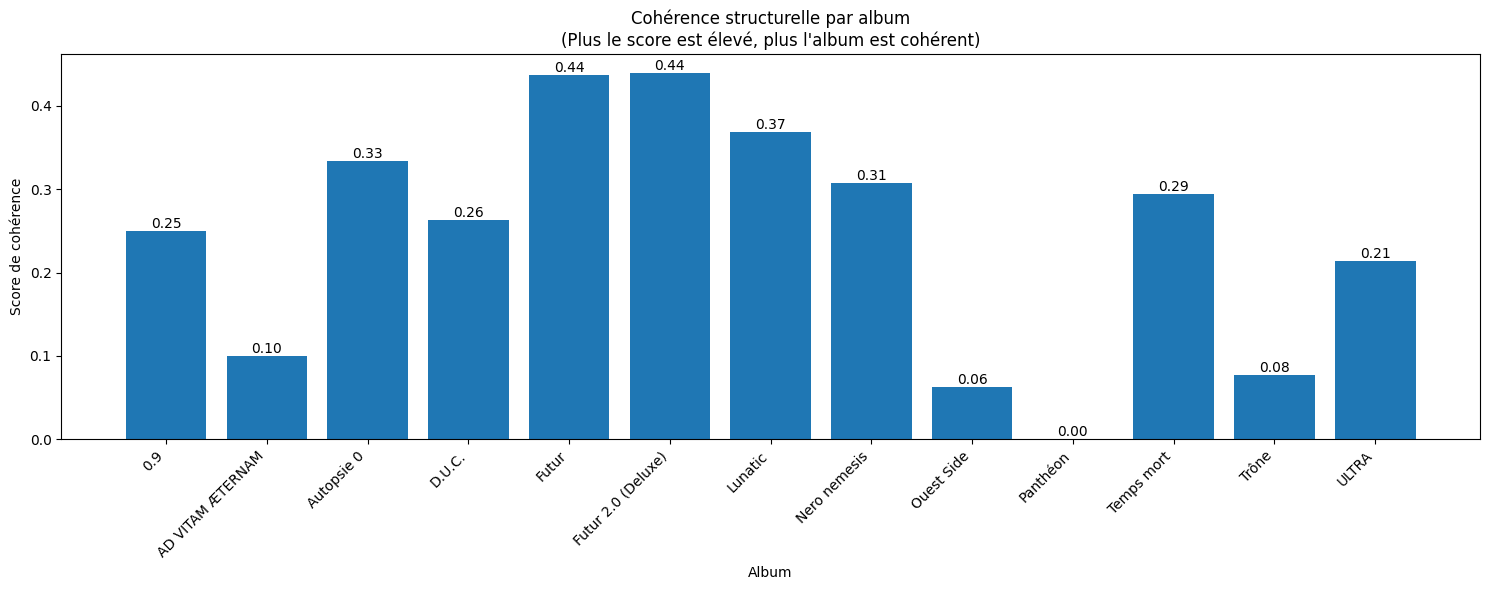


Statistiques de cohérence par album:

0.9:
- Nombre de patterns uniques: 12
- Nombre total de morceaux: 16
- Score de cohérence: 0.25

AD VITAM ÆTERNAM:
- Nombre de patterns uniques: 9
- Nombre total de morceaux: 10
- Score de cohérence: 0.10

Autopsie 0:
- Nombre de patterns uniques: 12
- Nombre total de morceaux: 18
- Score de cohérence: 0.33

D.U.C.:
- Nombre de patterns uniques: 14
- Nombre total de morceaux: 19
- Score de cohérence: 0.26

Futur:
- Nombre de patterns uniques: 9
- Nombre total de morceaux: 16
- Score de cohérence: 0.44

Futur 2.0 (Deluxe):
- Nombre de patterns uniques: 14
- Nombre total de morceaux: 25
- Score de cohérence: 0.44

Lunatic:
- Nombre de patterns uniques: 12
- Nombre total de morceaux: 19
- Score de cohérence: 0.37

Nero nemesis:
- Nombre de patterns uniques: 9
- Nombre total de morceaux: 13
- Score de cohérence: 0.31

Ouest Side:
- Nombre de patterns uniques: 15
- Nombre total de morceaux: 16
- Score de cohérence: 0.06

Panthéon:
- Nombre de patterns 

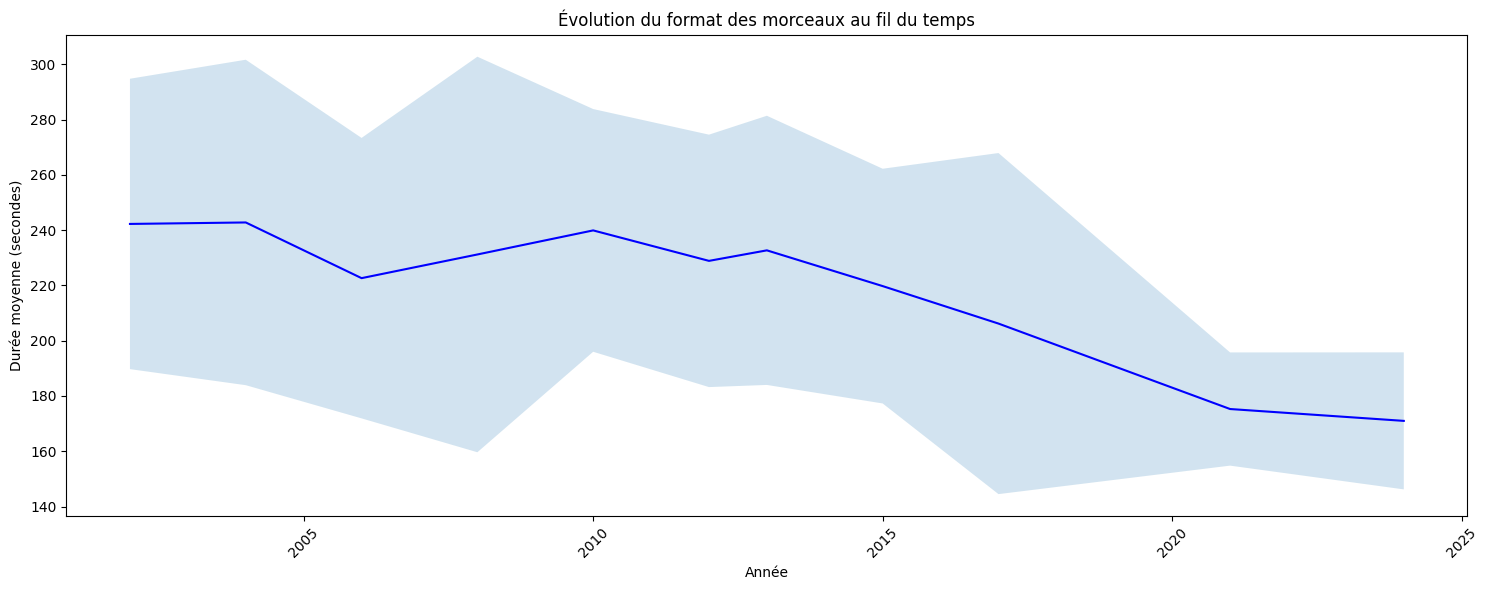


Évolution des formats:

2002:
- Durée moyenne: 242 secondes
- Écart-type: 53 secondes
- Nombre de morceaux: 17

2004:
- Durée moyenne: 243 secondes
- Écart-type: 59 secondes
- Nombre de morceaux: 13

2006:
- Durée moyenne: 223 secondes
- Écart-type: 51 secondes
- Nombre de morceaux: 16

2008:
- Durée moyenne: 231 secondes
- Écart-type: 72 secondes
- Nombre de morceaux: 16

2010:
- Durée moyenne: 240 secondes
- Écart-type: 44 secondes
- Nombre de morceaux: 19

2012:
- Durée moyenne: 229 secondes
- Écart-type: 46 secondes
- Nombre de morceaux: 16

2013:
- Durée moyenne: 233 secondes
- Écart-type: 49 secondes
- Nombre de morceaux: 25

2015:
- Durée moyenne: 220 secondes
- Écart-type: 42 secondes
- Nombre de morceaux: 32

2017:
- Durée moyenne: 206 secondes
- Écart-type: 62 secondes
- Nombre de morceaux: 31

2021:
- Durée moyenne: 175 secondes
- Écart-type: 20 secondes
- Nombre de morceaux: 14

2024:
- Durée moyenne: 171 secondes
- Écart-type: 25 secondes
- Nombre de morceaux: 10

3. Anal

C:\Users\yonas\AppData\Local\Temp\ipykernel_21264\2580213134.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patterns_by_period = df.groupby('période')['pattern'].value_counts().unstack(fill_value=0)


<Figure size 1500x600 with 0 Axes>

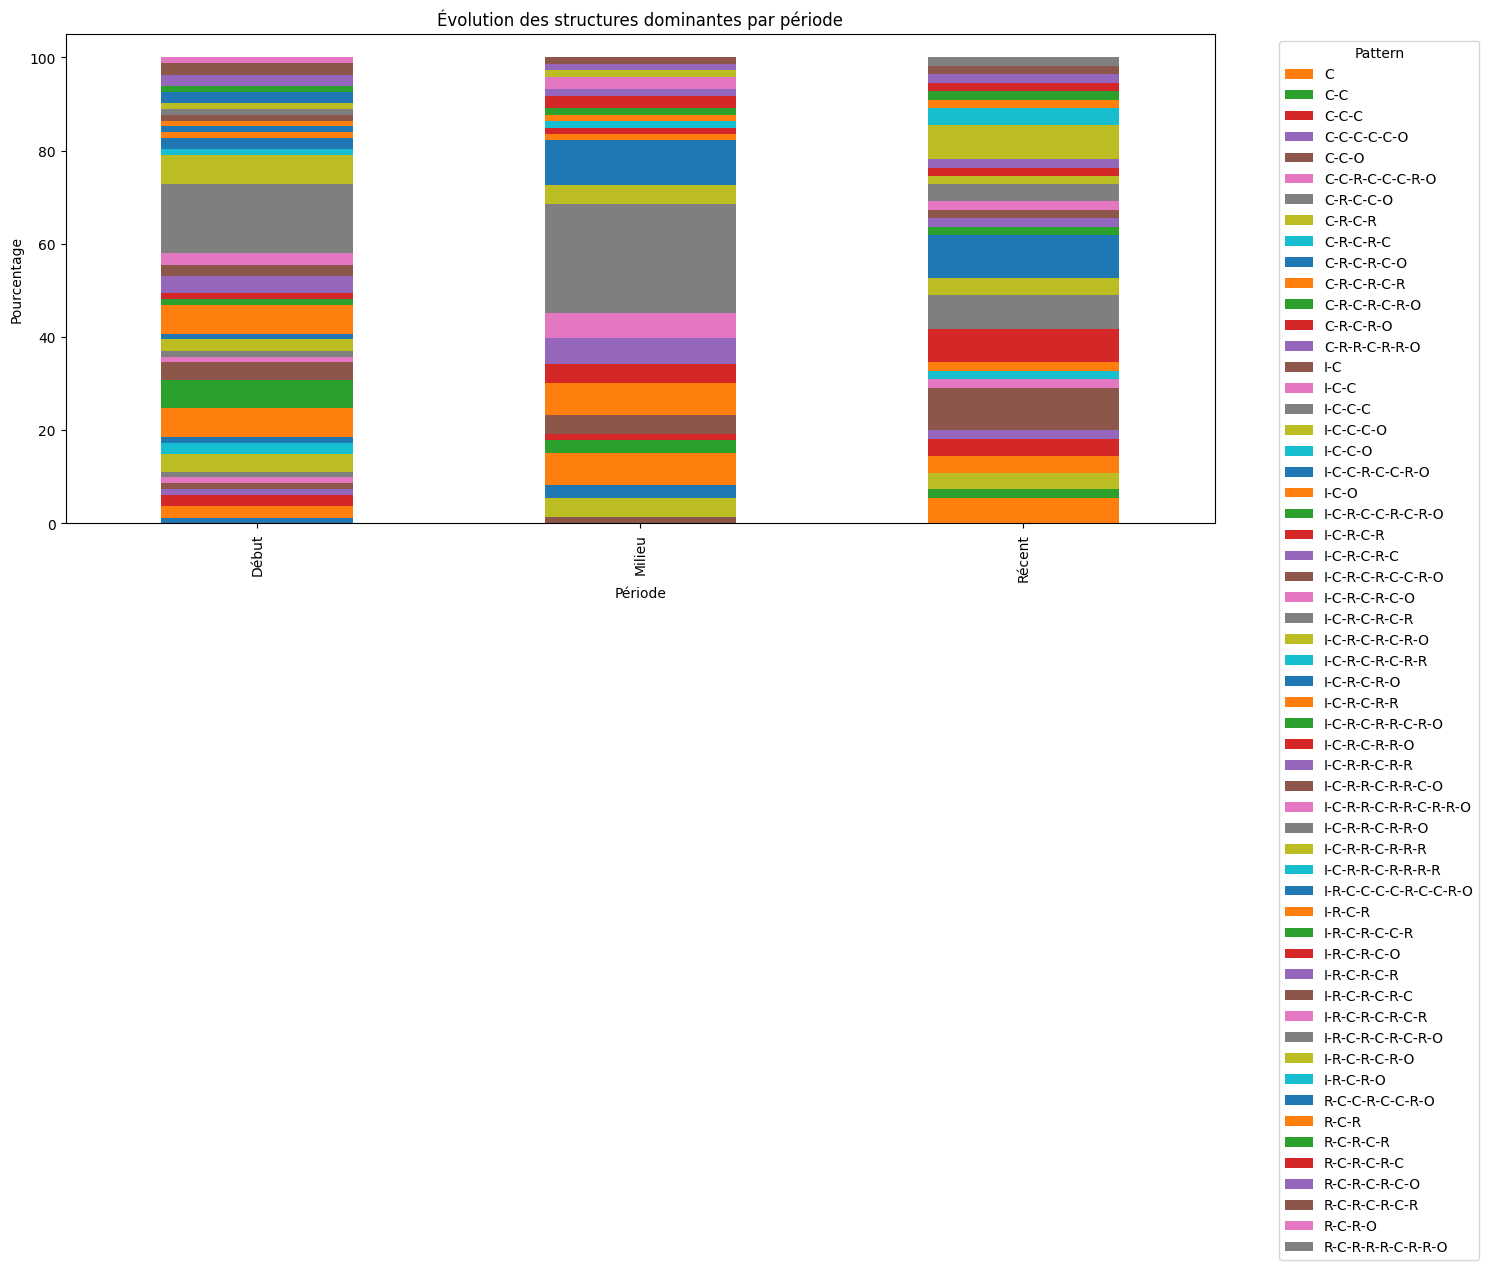


Tendances par période:

Début:
- I-C-R-C-R-C-R: 12 morceaux (14.8%)
- C-R-C-R-C-R: 5 morceaux (6.2%)
- C-R-C-R-C-R-O: 5 morceaux (6.2%)

Milieu:
- I-C-R-C-R-C-R: 17 morceaux (23.3%)
- I-C-R-C-R-O: 7 morceaux (9.6%)
- C-R-C-R-C-R: 5 morceaux (6.8%)

Récent:
- I-C: 5 morceaux (9.1%)
- I-C-R-C-R-O: 5 morceaux (9.1%)
- I-C-R-C-R: 4 morceaux (7.3%)

4. Analyse des spécificités de chaque ère


C:\Users\yonas\AppData\Local\Temp\ipykernel_21264\2580213134.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  era_stats = df.groupby('ère').agg({


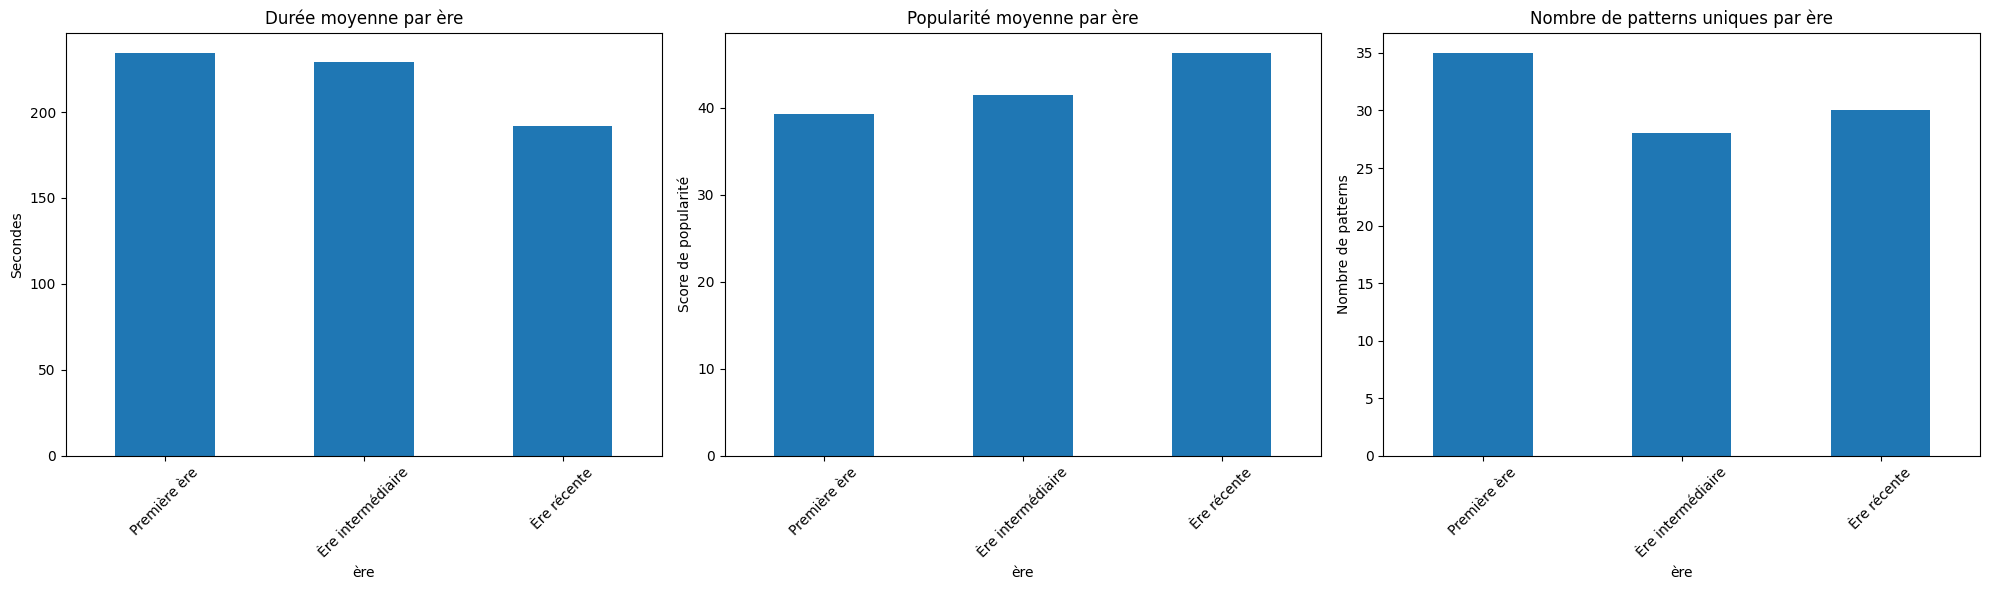


Caractéristiques par ère:
                   durée_sec  popularité  pattern
ère                                              
Première ère          234.44       39.24       35
Ère intermédiaire     229.01       41.42       28
Ère récente           191.93       46.27       30


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Cohérence structurelle par album
def analyze_album_coherence():
    # Calcul de la diversité des patterns par album
    album_diversity = df.groupby('album').agg({
        'pattern': ['nunique', 'count']
    })
    album_diversity.columns = ['unique_patterns', 'total_tracks']
    album_diversity['coherence_score'] = 1 - (album_diversity['unique_patterns'] / album_diversity['total_tracks'])
    
    # Visualisation
    plt.figure(figsize=(15, 6))
    bars = plt.bar(album_diversity.index, album_diversity['coherence_score'])
    plt.title('Cohérence structurelle par album\n(Plus le score est élevé, plus l\'album est cohérent)', fontsize=12)
    plt.xlabel('Album')
    plt.ylabel('Score de cohérence')
    plt.xticks(rotation=45, ha='right')
    
    # Ajout des valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques détaillées
    print("\nStatistiques de cohérence par album:")
    for album in album_diversity.index:
        print(f"\n{album}:")
        print(f"- Nombre de patterns uniques: {album_diversity.loc[album, 'unique_patterns']}")
        print(f"- Nombre total de morceaux: {album_diversity.loc[album, 'total_tracks']}")
        print(f"- Score de cohérence: {album_diversity.loc[album, 'coherence_score']:.2f}")

# 2. Évolution des formats
def analyze_format_evolution():
    # Calcul de la durée moyenne des morceaux par année
    yearly_duration = df.groupby('année')['durée_sec'].agg(['mean', 'std', 'count'])
    
    # Visualisation
    fig, ax1 = plt.subplots(figsize=(15, 6))
    
    # Durée moyenne
    ax1.plot(yearly_duration.index, yearly_duration['mean'], 'b-', label='Durée moyenne')
    ax1.fill_between(yearly_duration.index, 
                     yearly_duration['mean'] - yearly_duration['std'],
                     yearly_duration['mean'] + yearly_duration['std'],
                     alpha=0.2)
    
    ax1.set_xlabel('Année')
    ax1.set_ylabel('Durée moyenne (secondes)')
    ax1.set_title('Évolution du format des morceaux au fil du temps')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Statistiques
    print("\nÉvolution des formats:")
    for year in sorted(yearly_duration.index):
        print(f"\n{year}:")
        print(f"- Durée moyenne: {yearly_duration.loc[year, 'mean']:.0f} secondes")
        print(f"- Écart-type: {yearly_duration.loc[year, 'std']:.0f} secondes")
        print(f"- Nombre de morceaux: {yearly_duration.loc[year, 'count']}")

# 3. Tendances dans la construction des projets
def analyze_project_trends():
    # Analyse des patterns dominants par période
    df['période'] = pd.qcut(df['année'], q=3, labels=['Début', 'Milieu', 'Récent'])
    
    patterns_by_period = df.groupby('période')['pattern'].value_counts().unstack(fill_value=0)
    patterns_by_period_pct = patterns_by_period.div(patterns_by_period.sum(axis=1), axis=0) * 100
    
    # Visualisation
    plt.figure(figsize=(15, 6))
    patterns_by_period_pct.plot(kind='bar', stacked=True)
    plt.title('Évolution des structures dominantes par période')
    plt.xlabel('Période')
    plt.ylabel('Pourcentage')
    plt.legend(title='Pattern', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # Statistiques
    print("\nTendances par période:")
    for period in patterns_by_period.index:
        print(f"\n{period}:")
        top_patterns = patterns_by_period.loc[period].nlargest(3)
        for pattern, count in top_patterns.items():
            print(f"- {pattern}: {count} morceaux ({(count/patterns_by_period.loc[period].sum()*100):.1f}%)")

# 4. Spécificités de chaque ère
def analyze_era_specifics():
    # Définir les ères (par exemple, par tranches de 5 ans)
    df['ère'] = pd.cut(df['année'], bins=3, labels=['Première ère', 'Ère intermédiaire', 'Ère récente'])
    
    # Analyse des caractéristiques par ère
    era_stats = df.groupby('ère').agg({
        'durée_sec': 'mean',
        'popularité': 'mean',
        'pattern': lambda x: x.nunique(),
    }).round(2)
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Durée moyenne
    era_stats['durée_sec'].plot(kind='bar', ax=axes[0], title='Durée moyenne par ère')
    axes[0].set_ylabel('Secondes')
    
    # Popularité moyenne
    era_stats['popularité'].plot(kind='bar', ax=axes[1], title='Popularité moyenne par ère')
    axes[1].set_ylabel('Score de popularité')
    
    # Diversité des patterns
    era_stats['pattern'].plot(kind='bar', ax=axes[2], title='Nombre de patterns uniques par ère')
    axes[2].set_ylabel('Nombre de patterns')
    
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques détaillées
    print("\nCaractéristiques par ère:")
    print(era_stats)

# Exécution de toutes les analyses
print("1. Analyse de la cohérence structurelle par album")
analyze_album_coherence()

print("\n2. Analyse de l'évolution des formats")
analyze_format_evolution()

print("\n3. Analyse des tendances dans la construction des projets")
analyze_project_trends()

print("\n4. Analyse des spécificités de chaque ère")
analyze_era_specifics()